In [1]:
import os
from os import mkdir
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import sounddevice as sd
import soundfile as sf

# Hardware / stimulus presentation / data acquisition...
We need real-time hardware that:
- loops through a folder and presents each wav file (or other file) through a soundcard
- sends a trigger at the same time each sound starts
- saves trigger times to fileA
- record in another channel with HIGH accuracy a series of button presses while sound is playing
- saves tap times to a different fileB

## Final function to create a whole stimulus set for N subjets and T trials (Experiment 1)

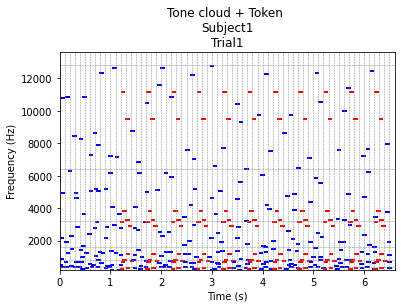

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1\exp1_subject01_total3\exp1_subject01_trial01.wav


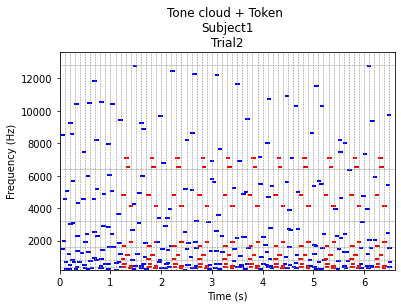

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1\exp1_subject01_total3\exp1_subject01_trial02.wav


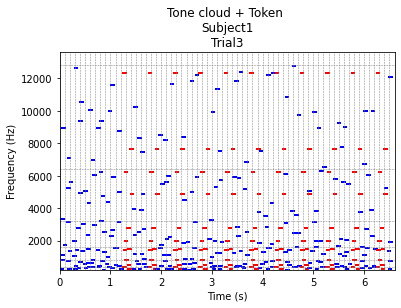

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1\exp1_subject01_total3\exp1_subject01_trial03.wav


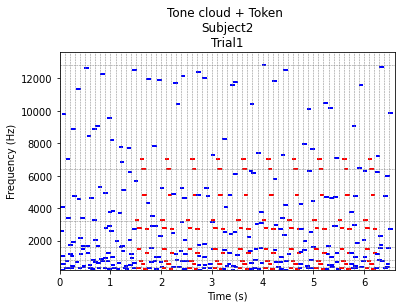

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1\exp1_subject02_total3\exp1_subject02_trial01.wav


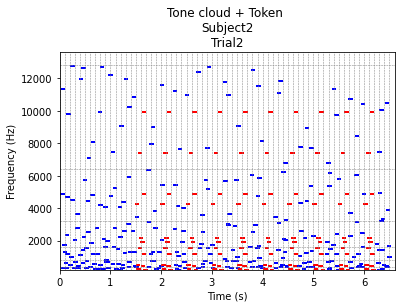

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1\exp1_subject02_total3\exp1_subject02_trial02.wav


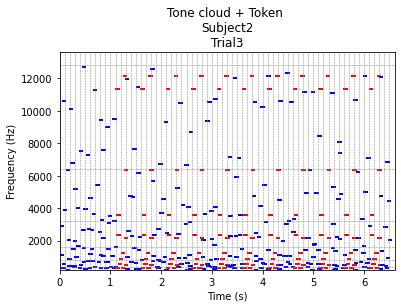

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1\exp1_subject02_total3\exp1_subject02_trial03.wav


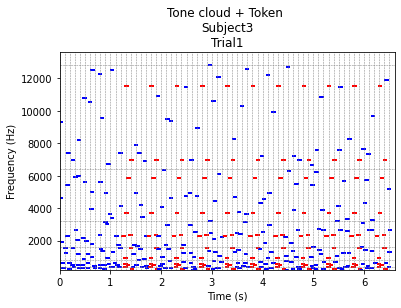

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1\exp1_subject03_total3\exp1_subject03_trial01.wav


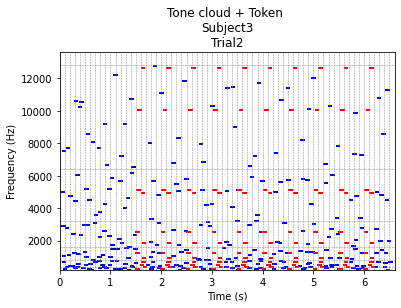

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1\exp1_subject03_total3\exp1_subject03_trial02.wav


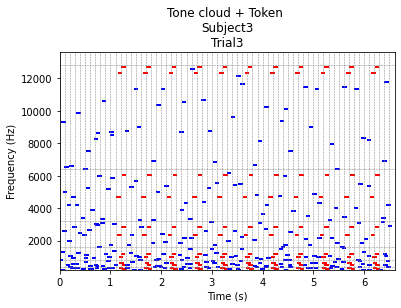

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1\exp1_subject03_total3\exp1_subject03_trial03.wav


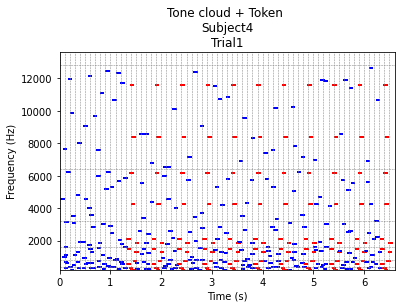

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1\exp1_subject04_total3\exp1_subject04_trial01.wav


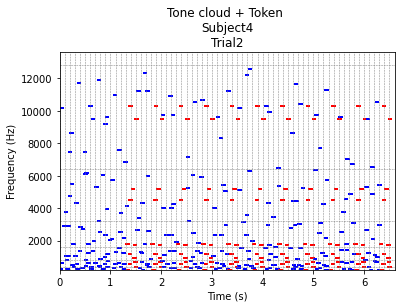

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1\exp1_subject04_total3\exp1_subject04_trial02.wav


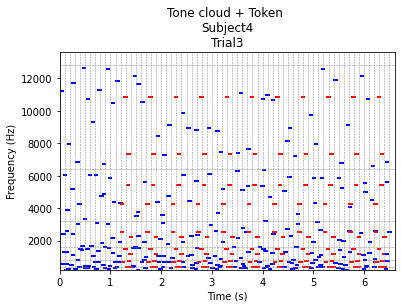

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1\exp1_subject04_total3\exp1_subject04_trial03.wav


In [2]:
Ntrials=3
Nsubjects=4

def exp1_stimulusset(Ntrials,Nsubjects):
    
    #Importing libraries
    import os
    from os import mkdir
    import numpy as np
    import random
    import matplotlib.pyplot as plt
    from scipy.io.wavfile import write
    import sounddevice as sd
    import soundfile as sf
    
    #Defining variables
    ntokenreps = 10  #how many times the target repeats in a trial
    tonedur = 0.05 
    minf = 200
    maxf = 12800
    noct = 6
    spectral_density = [1] #tones per octave   
    temporal_density = [10] #tones per second
    tempi = [0.5] #s, the inter-repeat interval of tokens 
    tempilist = [0.5]
    tokendur = 0.2 #target duration
    tokendur_ingrid =int(temporal_density[0]*tokendur)
    tempi_ingrid = int(temporal_density[0]*tempi[0])

    fs = 44100 #generate sounds with this fs
    fs48 = 48828 #convert to this fs for TDT equipment
    maxf48k = fs48/2
    trialseed = 888

    tokenstartrange=np.linspace(1,1.5, num=6) #range from where I can choose to strat my token
    tokenstart=np.random.choice(tokenstartrange)
    mintokenstart = 1 
    maxtokenstart = 1.5 #first token starts between 1-1.5s into (random) tone cloud
    np.random.seed(trialseed)  #command to set the seed
    ntrialspercond = 60
    stimdb = 85
    wrongtotaltime=tokenstart+(tempi*ntokenreps)
    totaltime=maxtokenstart+(tempi[0]*ntokenreps)+1/temporal_density[0]
    targetrms = (10**(-94/20))*(10**(stimdb/20)) #convertion of dB to amplitude. the number we would use
    targetrms_wav = 0.1 #0.4  
    
    #Computing hann envelope (for creating a smooth on and off ramp to sounds)
    hanndur = 0.005
    thann = np.arange(1/fs, hanndur+1/fs, 1/fs)
    ramp = np.cos(2*np.pi*0.5/hanndur*thann)
    ttone = np.arange(1/fs, tonedur+1/fs, 1/fs)
    env = np.ones(ttone.shape)
    env[:len(ramp)] = np.flip(ramp)
    env[-len(ramp):] = ramp
    env=(env+1)/2
    #plt.plot(ttone, env)
    
    #Creating the freq_list and the timegrid
    trialct = 0
    for s in range(len(spectral_density)):
        specdens = spectral_density[s]
        freq_list = np.logspace(np.log10(minf),np.log10(maxf),specdens*noct+1)
        
    timegrid=np.linspace(0,totaltime, num=int(totaltime/(1/(temporal_density[0]))+2)) 
    
    
    #Looping trough the desired number of subjects and number of trials.
    for ns in range(1, Nsubjects + 1):
        np.random.seed(ns)
        
        subjID= str(ns).zfill(2)
        subjfolder= f"exp1_subject{subjID}_total{Ntrials}"
        subjpath = os.path.join("C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp1", subjfolder)
        os.makedirs(subjpath, exist_ok=True)
        
        for nt in range(1, Ntrials + 1):
            
            #Creating random background(latencymat, freqmat)
            latencymat = np.zeros((len(timegrid) - 1, len(freq_list) - 1))
            freqmat = np.zeros((len(timegrid) - 1, len(freq_list) - 1))

            for t in range(len(timegrid) - 2):     
                for f in range(len(freq_list) - 1):

                    start_time = timegrid[t]
                    end_time = timegrid[t + 1]
                    ftimetone = np.random.uniform(start_time, end_time) - start_time

                    fstart_time = freq_list[f]
                    fend_time = freq_list[f + 1]
                    ftone = np.random.uniform(fstart_time, fend_time)

                    latencymat[t, f] = ftimetone
                    freqmat[t, f] = ftone

            latencymat = latencymat.transpose()
            freqmat = freqmat.transpose()
            
#             print("Latencymat:\n",latencymat)
#             print("\nFreqmat:\n",freqmat)
            
            
            #Creating token and startids
            tokenstart=np.random.choice(tokenstartrange)
            tokenstarttime=tokenstart # just redefining the name
            tokenendtime=tokenstarttime+tokendur 

            tokenstartcondition = np.isclose(timegrid, tokenstarttime)
            start_idx=np.where(tokenstartcondition)[0][0]

            end_idx=int(start_idx+tokendur_ingrid)
            latencytoken=latencymat[:,np.arange(start_idx,end_idx,1)]
            freqtoken=freqmat[:,np.arange(start_idx,end_idx,1)]

            latencyshape = latencymat.shape
            sid = np.arange(start_idx,latencyshape[1],tempi_ingrid)
            startids = [x for x in sid if x<(latencyshape[1]-2)]
            
#             print("latencytoken:\n",latencytoken)
#             print("\nfreqtoken:\n",freqtoken)
#             print("\nstartids:\n", startids)
            
            #Creating the final soundmat of the tonecloud+token
            token_latencymat = latencymat
            token_freqmat = freqmat
            
            baselatencymat=np.zeros(latencymat.shape)
            basefreqmat=np.zeros(freqmat.shape)

            #Replacing sections of tone cloud with token
            for s in startids:
                token_latencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken
                token_freqmat[:, np.arange(s,s+tokendur_ingrid,1)] = freqtoken
                
                baselatencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken
                basefreqmat[:, np.arange(s,s+tokendur_ingrid,1)] = freqtoken

                binarbasefreqmat = np.where(basefreqmat > 0, 1, basefreqmat)
                binarbaselatencymat = np.where(baselatencymat > 0, 1, baselatencymat)

#             print("Final token_latencymat:\n",token_latencymat)
#             print("\nFinal token_freqmat:\n",token_freqmat)

            tokensoundmat=np.zeros(int(totaltime*fs))
    
            for t in range(len(timegrid) - 2):     
                for f in range(len(freq_list) - 1):

                    ftimetone = token_latencymat[f,t]
                    ftone = token_freqmat[f,t]

                    grid_start = timegrid[t]

                    amp = np.sin(2*np.pi*ftone*ttone) #make the tone
                    amp = amp*env #hanning env already calculated outside

                    tonestartsamp = int((grid_start+ftimetone)*fs)+1
                    toneendsamp = tonestartsamp+len(amp)

                    #print(grid_start,tonestartsamp)


                    tokensoundmat[tonestartsamp:toneendsamp]=tokensoundmat[tonestartsamp:toneendsamp]+amp

                    plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='blue', linewidth=2)
                    if binarbaselatencymat[f,t]==1:
                        plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='red', linewidth=2)

            for t in timegrid:
                linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
            for f in freq_list:
                linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)

            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.title(f'Tone cloud + Token \nSubject{ns}\nTrial{nt}')
            plt.xlim(0, totaltime)
            plt.ylim(minf, maxf+800)
            plt.show()
            
            
            #Creating and saving wav file
            
            trial= str(nt).zfill(2)
            filename= f"exp1_subject{subjID}_trial{trial}.wav"
            path_filename = os.path.join(subjpath, filename)
            
            tokensoundmat = tokensoundmat/max(abs(tokensoundmat))
            sf.write(path_filename, tokensoundmat, fs)
            
            
            print(f"Saved: {path_filename}")
            
exp1_stimulusset(Ntrials,Nsubjects)

## Final function to create a whole stimulus set with a jittered token for N subjets and T trials (Experiment 2)

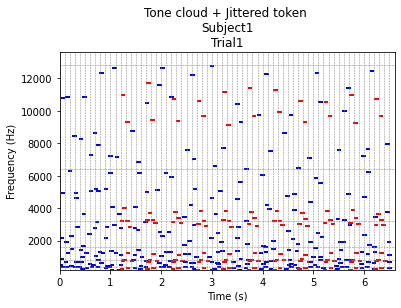

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2\exp2_subject01_total3\exp2_subject01_trial01.wav


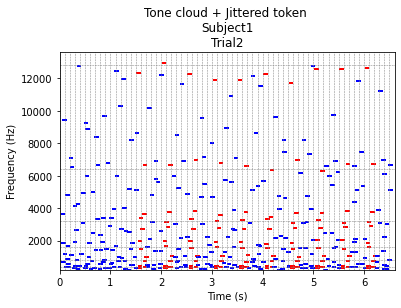

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2\exp2_subject01_total3\exp2_subject01_trial02.wav


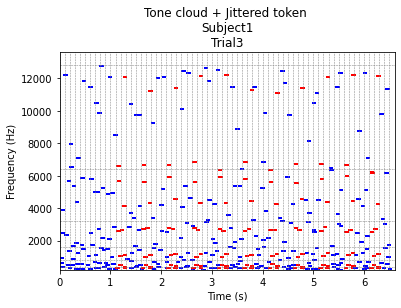

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2\exp2_subject01_total3\exp2_subject01_trial03.wav


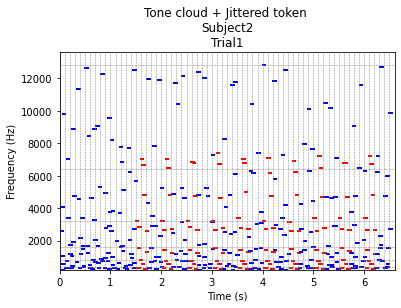

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2\exp2_subject02_total3\exp2_subject02_trial01.wav


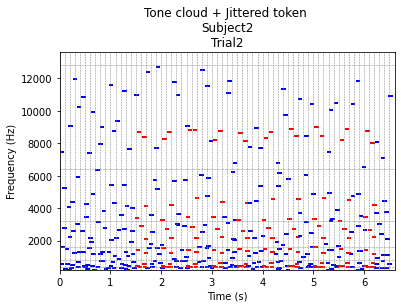

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2\exp2_subject02_total3\exp2_subject02_trial02.wav


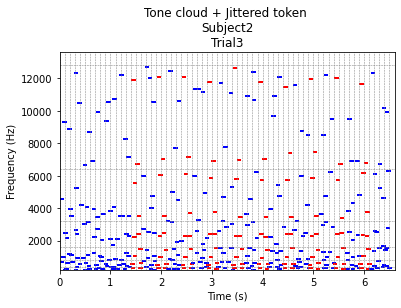

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2\exp2_subject02_total3\exp2_subject02_trial03.wav


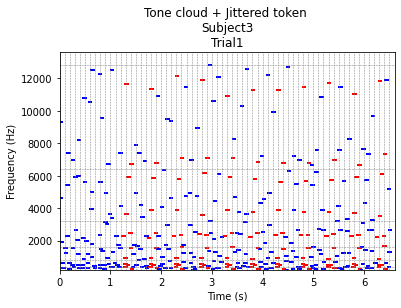

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2\exp2_subject03_total3\exp2_subject03_trial01.wav


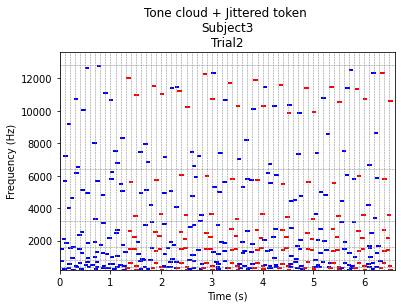

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2\exp2_subject03_total3\exp2_subject03_trial02.wav


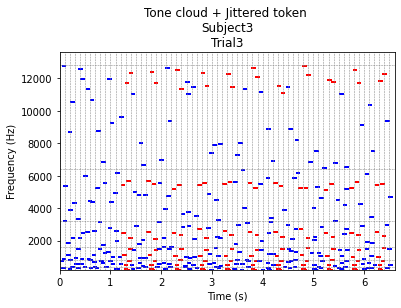

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2\exp2_subject03_total3\exp2_subject03_trial03.wav


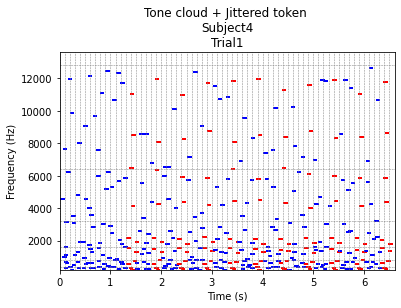

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2\exp2_subject04_total3\exp2_subject04_trial01.wav


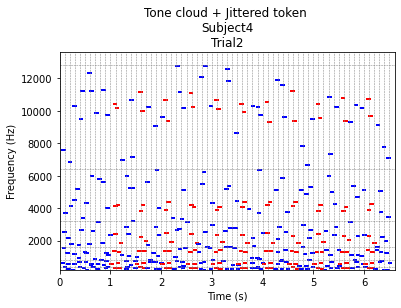

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2\exp2_subject04_total3\exp2_subject04_trial02.wav


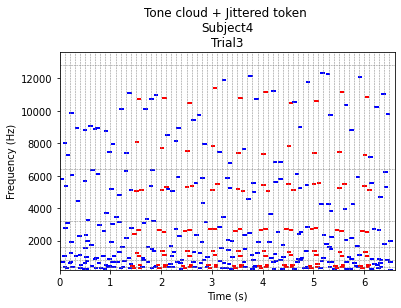

Saved: C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2\exp2_subject04_total3\exp2_subject04_trial03.wav


In [23]:
Ntrials=3
Nsubjects=4

def exp2_stimulusset(Ntrials,Nsubjects):
    
    #Importing libraries
    import os
    from os import mkdir
    import numpy as np
    import random
    import matplotlib.pyplot as plt
    from scipy.io.wavfile import write
    import sounddevice as sd
    import soundfile as sf
    
    #Defining variables
    ntokenreps = 10  #how many times the target repeats in a trial
    tonedur = 0.05 
    minf = 200
    maxf = 12800
    noct = 6
    spectral_density = [1] #tones per octave   
    temporal_density = [10] #tones per second
    tempi = [0.5] #s, the inter-repeat interval of tokens 
    tempilist = [0.5]
    tokendur = 0.2 #target duration
    tokendur_ingrid =int(temporal_density[0]*tokendur)
    tempi_ingrid = int(temporal_density[0]*tempi[0])

    fs = 44100 #generate sounds with this fs
    fs48 = 48828 #convert to this fs for TDT equipment
    maxf48k = fs48/2
    trialseed = 888

    tokenstartrange=np.linspace(1,1.5, num=6) #range from where I can choose to strat my token
    tokenstart=np.random.choice(tokenstartrange)
    mintokenstart = 1 
    maxtokenstart = 1.5 #first token starts between 1-1.5s into (random) tone cloud
    np.random.seed(trialseed)  #command to set the seed
    ntrialspercond = 60
    stimdb = 85
    wrongtotaltime=tokenstart+(tempi*ntokenreps)
    totaltime=maxtokenstart+(tempi[0]*ntokenreps)+1/temporal_density[0]
    targetrms = (10**(-94/20))*(10**(stimdb/20)) #convertion of dB to amplitude. the number we would use
    targetrms_wav = 0.1 #0.4  
    
    #Computing hann envelope (for creating a smooth on and off ramp to sounds)
    hanndur = 0.005
    thann = np.arange(1/fs, hanndur+1/fs, 1/fs)
    ramp = np.cos(2*np.pi*0.5/hanndur*thann)
    ttone = np.arange(1/fs, tonedur+1/fs, 1/fs)
    env = np.ones(ttone.shape)
    env[:len(ramp)] = np.flip(ramp)
    env[-len(ramp):] = ramp
    env=(env+1)/2
    #plt.plot(ttone, env)
    
    #Creating the freq_list and the timegrid
    trialct = 0
    for s in range(len(spectral_density)):
        specdens = spectral_density[s]
        freq_list = np.logspace(np.log10(minf),np.log10(maxf),specdens*noct+1)
        
    timegrid=np.linspace(0,totaltime, num=int(totaltime/(1/(temporal_density[0]))+2)) 
    
    
    #Looping trough the desired number of subjects and number of trials.
    for ns in range(1, Nsubjects + 1):
        np.random.seed(ns)
        
        subjID= str(ns).zfill(2)
        subjfolder= f"exp2_subject{subjID}_total{Ntrials}"
        subjpath = os.path.join("C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/exp2", subjfolder)
        os.makedirs(subjpath, exist_ok=True)
        
        for nt in range(1, Ntrials + 1):
            
            #Creating random background(latencymat, freqmat)
            latencymat = np.zeros((len(timegrid) - 1, len(freq_list) - 1))
            freqmat = np.zeros((len(timegrid) - 1, len(freq_list) - 1))

            for t in range(len(timegrid) - 2):     
                for f in range(len(freq_list) - 1):

                    start_time = timegrid[t]
                    end_time = timegrid[t + 1]
                    ftimetone = np.random.uniform(start_time, end_time) - start_time

                    fstart_time = freq_list[f]
                    fend_time = freq_list[f + 1]
                    ftone = np.random.uniform(fstart_time, fend_time)

                    latencymat[t, f] = ftimetone
                    freqmat[t, f] = ftone

            latencymat = latencymat.transpose()
            freqmat = freqmat.transpose()
            
#             print("Latencymat:\n",latencymat)
#             print("\nFreqmat:\n",freqmat)
            
            
            #Creating token and startids
            tokenstart=np.random.choice(tokenstartrange)
            tokenstarttime=tokenstart # just redefining the name
            tokenendtime=tokenstarttime+tokendur 

            tokenstartcondition = np.isclose(timegrid, tokenstarttime)
            start_idx=np.where(tokenstartcondition)[0][0]

            end_idx=int(start_idx+tokendur_ingrid)
            latencytoken=latencymat[:,np.arange(start_idx,end_idx,1)]
            freqtoken=freqmat[:,np.arange(start_idx,end_idx,1)]

            latencyshape = latencymat.shape
            sid = np.arange(start_idx,latencyshape[1],tempi_ingrid)
            startids = [x for x in sid if x<(latencyshape[1]-2)]
            
#             print("latencytoken:\n",latencytoken)
#             print("\nfreqtoken:\n",freqtoken)
#             print("\nstartids:\n", startids)

            token_latencymat = latencymat
            jtoken_freqmat = freqmat

            latencyshape = latencymat.shape
            sid = np.arange(start_idx,latencyshape[1],tempi_ingrid)
            startids = [x for x in sid if x<(latencyshape[1]-2)]
            
            

            maxjitter = 1 # semitones, plus or minus
            jitterfreqtoken=np.zeros(freqtoken.shape)
            jitterperfreq=np.zeros(freqtoken.shape)

            jbaselatencymat=np.zeros(latencymat.shape)
            jbasefreqmat=np.zeros(freqmat.shape)

            # replace sections of tone cloud with token

            first_startid=startids[0]

            for s in startids:
                token_latencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken

                maxjitter = 1 # semitones, plus or minus
                jitterfreqtoken=np.zeros(freqtoken.shape)
                jitterperfreq=np.zeros(freqtoken.shape)

                for i in range(freqtoken.shape[0]):
                    for j in range(freqtoken.shape[1]):
                        randjitterST = np.random.random(1)*maxjitter*2-maxjitter
                        jitterfreq = freqtoken[i,j] * 2**(randjitterST/12)
                        jitterfreqtoken[i][j]=jitterfreq
                        jitterperfreq[i][j]=randjitterST
#                 print(jitterperfreq)
#                 print(jitterfreqtoken)

                jtoken_freqmat[:, np.arange(s,s+tokendur_ingrid,1)] = jitterfreqtoken

                jbaselatencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken
                jbasefreqmat[:, np.arange(s,s+tokendur_ingrid,1)] = jitterfreqtoken

                jbinarbasefreqmat = np.where(jbasefreqmat > 0, 1, jbasefreqmat)


#             print("Final token_latencymat:\n",token_latencymat)
#             print("\nFinal token_freqmat:\n",token_freqmat)

            jtokensoundmat=np.zeros(int(totaltime*fs))

            for t in range(len(timegrid) - 2):     
                for f in range(len(freq_list) - 1):

                    ftimetone = token_latencymat[f,t]
                    ftone = jtoken_freqmat[f,t]

                    grid_start = timegrid[t]

                    amp = np.sin(2*np.pi*ftone*ttone) #make the tone
                    amp = amp*env #hanning env already calculated outside

                    tonestartsamp = int((grid_start+ftimetone)*fs)+1
                    toneendsamp = tonestartsamp+len(amp)

                    #print(grid_start,tonestartsamp)


                    jtokensoundmat[tonestartsamp:toneendsamp]=jtokensoundmat[tonestartsamp:toneendsamp]+amp

                    plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='blue', linewidth=2)
                    if jbinarbasefreqmat[f,t]==1:
                        plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='red', linewidth=2)

            for t in timegrid:
                linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
            for f in freq_list:
                linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)

            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.title(f'Tone cloud + Jittered token \nSubject{ns}\nTrial{nt}')
            plt.xlim(0, totaltime)
            plt.ylim(minf, maxf+800)
            plt.show()
            
            
            #Creating and saving wav file
            
            trial= str(nt).zfill(2)
            filename= f"exp2_subject{subjID}_trial{trial}.wav"
            path_filename = os.path.join(subjpath, filename)
            
            jtokensoundmat = jtokensoundmat/max(abs(jtokensoundmat))
            sf.write(path_filename, jtokensoundmat, fs)
            
            
            print(f"Saved: {path_filename}")
            
exp2_stimulusset(Ntrials,Nsubjects)

## Separated functions

### The Function Dictionary! 

Here I summarize the functions created so far (the most important ones). The way they are written is the exact way they should be called in the code. 

* #### exp1_stimulusset(Ntrials,Nsubjects)
Creates a whole stimulus set for N subjets and T trials for Experiment 1, given a desired number of subjects and trials. It saves the wav audio files for the final tonecloud+token

* #### exp2_stimulusset(Ntrials,Nsubjects)
Creates a whole stimulus set for N subjets and T trials for Experiment 2, given a desired number of subjects and trials. It saves the wav audio files for the final tonecloud+ Jittered token

* #### freqlist_and_timegrid(spectral_density,temporal_density)
Creates a frequency and a time matrix (returns freq_list, timegrid), given an spectral and a temporal density


*How to call it to save the returned values as new external variables:

freq_list, timegrid= freqlist_and_timegrid(spectral_density,temporal_density)  

* #### background_tonecloud(timegrid, freq_list)
Creates a random background tonecloud (returns latencymat, freqmat), given a timegrid and a freq_list


*How to call it to save the returned values as new external variables:

latencymat, freqmat= background_tonecloud(timegrid, freq_list)

* #### token_startids(latencymat, freqmat)
Creates the tokens and randomnized ids for them (returns latencytoken, freqtoken, startids), given a latencymat and a freqmat.


*How to call it to save the returned values as new external variables:

latencytoken, freqtoken, startids= token_startids(latencymat, freqmat)


* #### token_tonecloud(latencytoken, freqtoken, startids)
Sticks the generated tokens into a background tonecloud, creating tonecloud+token matrix for time and frequencies (returns a token_latencymat, token_freqmat and a tokensoundmat), given a latencytoken, freqtoken and startids.

*How to call it to save the returned values as new external variables:

token_latencymat, token_freqmat, tokensoundmat= token_tonecloud(latencytoken, freqtoken, startids)

* #### add_freqjitter(freqtoken)
Function to add jitter to each value of the token. It returns a modified token matrix with jitter, and also saves the specific amount of jitter that any token receives into a variable jitterperfreq, just in case we need to check this in the future.

*How to call it to save the returned values as new external variables:

jitterfreqtoken, jitterperfreq=add_freqjitter(freqtoken)

* #### jitter_tokentonecloud(latencytoken, freqtoken, startids)
Sticks the generated tokens with jitter into a background tonecloud, creating tonecloud+jittered token matrix for time and frequencies (returns a token_latencymat, jtoken_freqmat and a jtokensoundmat), given a latencytoken, freqtoken and startids.

*How to call it to save the returned values as new external variables:

token_latencymat, jtoken_freqmat, jtokensoundmat= jitter_tokentonecloud(latencytoken, freqtoken, startids)


* #### tokensoundmat_to_wav(tokensoundmat, fs, output_path, filename)
Saves the generated tokensoundmat as a wav file to a specified path, given a soundmat, fs, path and filename.

In [2]:
#Defining variables

ntokenreps = 10  #how many times the target repeats in a trial
tonedur = 0.05 
minf = 200
maxf = 12800
noct = 6
spectral_density = [1] #tones per octave   
temporal_density = [10] #tones per second
tempi = [0.5] #s, the inter-repeat interval of tokens 
tempilist = [0.5]
tokendur = 0.2 #target duration
tokendur_ingrid =int(temporal_density[0]*tokendur)
tempi_ingrid = int(temporal_density[0]*tempi[0])

fs = 44100 #generate sounds with this fs
fs48 = 48828 #convert to this fs for TDT equipment
maxf48k = fs48/2
trialseed = 888

tokenstartrange=np.linspace(1,1.5, num=6) #range from where I can choose to strat my token
tokenstart=np.random.choice(tokenstartrange)
mintokenstart = 1 
maxtokenstart = 1.5 #first token starts between 1-1.5s into (random) tone cloud
np.random.seed(trialseed)  #command to set the seed
ntrialspercond = 60
stimdb = 85
wrongtotaltime=tokenstart+(tempi*ntokenreps)
totaltime=maxtokenstart+(tempi[0]*ntokenreps)+1/temporal_density[0]
targetrms = (10**(-94/20))*(10**(stimdb/20)) #convertion of dB to amplitude. the number we would use
targetrms_wav = 0.1 #0.4

In [3]:
#compute hann envelope (for creating a smooth on and off ramp to sounds)

hanndur = 0.005
thann = np.arange(1/fs, hanndur+1/fs, 1/fs)
ramp = np.cos(2*np.pi*0.5/hanndur*thann)
ttone = np.arange(1/fs, tonedur+1/fs, 1/fs)
env = np.ones(ttone.shape)
env[:len(ramp)] = np.flip(ramp)
env[-len(ramp):] = ramp
env=(env+1)/2
#plt.plot(ttone, env)

In [4]:
trialct = 0
for s in range(len(spectral_density)):
    specdens = spectral_density[s]
    freq_list = np.logspace(np.log10(minf),np.log10(maxf),specdens*noct+1)
    

timegrid=np.linspace(0,totaltime, num=int(totaltime/(1/(temporal_density[0]))+2))                     
        

In [59]:
#to create the timegrid and freq_list in a same function

def freqlist_and_timegrid(spectral_density,temporal_density):
    trialct = 0
    for s in range(len(spectral_density)):
        specdens = spectral_density[s]
        freq_list = np.logspace(np.log10(minf),np.log10(maxf),specdens*noct+1)

    timegrid=np.linspace(0,totaltime, num=int(totaltime/(1/(temporal_density[0]))+2))  
    
    return freq_list, timegrid

freq_list, timegrid= freqlist_and_timegrid(spectral_density,temporal_density)    

### Function for the random background tone cloud

In [11]:

def background_tonecloud(timegrid, freq_list):
    latencymat = np.zeros((len(timegrid) - 1, len(freq_list) - 1))
    freqmat = np.zeros((len(timegrid) - 1, len(freq_list) - 1))
    
    for t in range(len(timegrid) - 2):     
        for f in range(len(freq_list) - 1):
            
            start_time = timegrid[t]
            end_time = timegrid[t + 1]
            ftimetone = np.random.uniform(start_time, end_time) - start_time
            
            fstart_time = freq_list[f]
            fend_time = freq_list[f + 1]
            ftone = np.random.uniform(fstart_time, fend_time)
            
            latencymat[t, f] = ftimetone
            freqmat[t, f] = ftone

    latencymat = latencymat.transpose()
    freqmat = freqmat.transpose()
    
    #print("Final latencymat:\n", latencymat)
    #print("\nFinal freqmat:\n", freqmat)
    
    soundmat=np.zeros(int(totaltime*fs))
    
    for t in range(len(timegrid) - 2):     
        for f in range(len(freq_list) - 1):
            
            ftimetone = latencymat[f,t]
            ftone = freqmat[f,t]

            grid_start = timegrid[t]
            
            amp = np.sin(2*np.pi*ftone*ttone) #make the tone
            amp = amp*env #hanning env already calculated outside
            
            tonestartsamp = int((grid_start+ftimetone)*fs)+1
            toneendsamp = tonestartsamp+len(amp)
            
            #print(grid_start,tonestartsamp)

        
            soundmat[tonestartsamp:toneendsamp]=soundmat[tonestartsamp:toneendsamp]+amp

#             plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='blue', linewidth=2)
    
#     for t in timegrid:
#         linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
#     for f in freq_list:
#         linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
#     plt.xlabel('Time (s)')
#     plt.ylabel('Frequency (Hz)')
#     plt.title('Tone cloud')
#     plt.xlim(0, totaltime)
#     plt.ylim(minf, maxf+800)
#     plt.show()
    
    return latencymat, freqmat
    

latencymat, freqmat= background_tonecloud (timegrid, freq_list) #save the results into variables to use later

### Function for startids and token generation

In [16]:
def token_startids(latencymat, freqmat):
    tokenstart=np.random.choice(tokenstartrange)
    tokenstarttime=tokenstart # just redefining the name
    tokenendtime=tokenstarttime+tokendur 

    tokenstartcondition = np.isclose(timegrid, tokenstarttime)
    start_idx=np.where(tokenstartcondition)[0][0]

    end_idx=int(start_idx+tokendur_ingrid)
    latencytoken=latencymat[:,np.arange(start_idx,end_idx,1)]
    freqtoken=freqmat[:,np.arange(start_idx,end_idx,1)]
        
    
    latencyshape = latencymat.shape
    sid = np.arange(start_idx,latencyshape[1],tempi_ingrid)
    startids = [x for x in sid if x<(latencyshape[1]-2)]
    
#     print("latencytoken:\n",latencytoken)
#     print("\nfreqtoken:\n",freqtoken)
#     print("\nstartids:\n", startids)
    
    return latencytoken, freqtoken, startids

latencytoken, freqtoken, startids=token_startids(latencymat, freqmat) 

### Function to stick tone cloud into background

In [32]:
def token_tonecloud(latencytoken, freqtoken, startids):
    token_latencymat = latencymat
    token_freqmat = freqmat

    # replace sections of tone cloud with token
    for s in startids:
        token_latencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken
        token_freqmat[:, np.arange(s,s+tokendur_ingrid,1)] = freqtoken

#     print("Final token_latencymat:\n",token_latencymat)
#     print("\nFinal token_freqmat:\n",token_freqmat)

    tokensoundmat=np.zeros(int(totaltime*fs))
    
    for t in range(len(timegrid) - 2):     
        for f in range(len(freq_list) - 1):
            
            ftimetone = token_latencymat[f,t]
            ftone = token_freqmat[f,t]

            grid_start = timegrid[t]
            
            amp = np.sin(2*np.pi*ftone*ttone) #make the tone
            amp = amp*env #hanning env already calculated outside
            
            tonestartsamp = int((grid_start+ftimetone)*fs)+1
            toneendsamp = tonestartsamp+len(amp)
            
            #print(grid_start,tonestartsamp)

        
            tokensoundmat[tonestartsamp:toneendsamp]=tokensoundmat[tonestartsamp:toneendsamp]+amp

#            plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='blue', linewidth=2)
    
#     for t in timegrid:
#         linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
#     for f in freq_list:
#         linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
#     plt.xlabel('Time (s)')
#     plt.ylabel('Frequency (Hz)')
#     plt.title('Tone cloud + Token')
#     plt.xlim(0, totaltime)
#     plt.ylim(minf, maxf+800)
#     plt.show()
    
    return token_latencymat, token_freqmat, tokensoundmat

token_latencymat, token_freqmat, tokensoundmat= token_tonecloud(latencytoken, freqtoken, startids)

### Function to add jitter

### Experiment 2 adds jitter to freqtoken
1. not in a function, try taking a freqtoken and add jitter to each value in the token
2. make a new function that loops through startids, computes the jittered token, and sticks the jittered token into background (basically replacing step 3 from expt 1)
3. create a new big function that does all of that for N number of trials and a given random seed, and saves all wav files in a folder called expt1_Ntrials_seed(or subjID)... filenames should be expt1_seed_trialX (if N<10, save it as '0n')
4. the step 5 from before should now use a filename/structure of expt2_...


In [92]:
def add_freqjitter(freqtoken):
    maxjitter = 1 # semitones, plus or minus
    jitterfreqtoken=np.zeros(freqtoken.shape)
    jitterperfreq=np.zeros(freqtoken.shape)

    for i in range(freqtoken.shape[0]):
        for j in range(freqtoken.shape[1]):
            randjitterST = np.random.random(1)*maxjitter*2-maxjitter
            jitterfreq = freqtoken[i,j] * 2**(randjitterST/12)
            jitterfreqtoken[i][j]=jitterfreq
            jitterperfreq[i][j]=randjitterST
    print(randjitters)
    print(jitterfreqtoken)
            

    return jitterfreqtoken, jitterperfreq

jitterfreqtoken, jitterperfreq=add_freqjitter(freqtoken)
    

[[ 1.95783196 -1.91060084]
 [-1.01480551  0.71347828]
 [-0.74683739  1.74087761]
 [ 0.34115727 -1.32865155]
 [ 0.46784093 -0.03265648]
 [ 1.70509559  1.54809377]]
[[  260.97897511   222.17524675]
 [  606.35009077   402.93747923]
 [ 1317.43851324  1341.9977085 ]
 [ 2007.87177644  2580.93413236]
 [ 3694.77063679  4319.90625395]
 [12596.98314737  7462.29517237]]


### Function to stick the jittered tone cloud into background

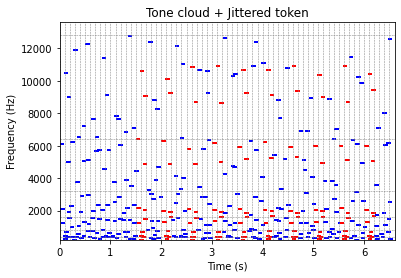

In [22]:
def jitter_tokentonecloud(latencytoken, freqtoken, startids):
    token_latencymat = latencymat
    jtoken_freqmat = freqmat

    latencyshape = latencymat.shape
    sid = np.arange(start_idx,latencyshape[1],tempi_ingrid)
    startids = [x for x in sid if x<(latencyshape[1]-2)]



    maxjitter = 1 # semitones, plus or minus
    jitterfreqtoken=np.zeros(freqtoken.shape)
    jitterperfreq=np.zeros(freqtoken.shape)

    jbaselatencymat=np.zeros(latencymat.shape)
    jbasefreqmat=np.zeros(freqmat.shape)

    # replace sections of tone cloud with token

    for s in startids:
        token_latencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken

        maxjitter = 1 # semitones, plus or minus
        jitterfreqtoken=np.zeros(freqtoken.shape)
        jitterperfreq=np.zeros(freqtoken.shape)

        for i in range(freqtoken.shape[0]):
            for j in range(freqtoken.shape[1]):
                randjitterST = np.random.random(1)*maxjitter*2-maxjitter
                jitterfreq = freqtoken[i,j] * 2**(randjitterST/12)
                jitterfreqtoken[i][j]=jitterfreq
                jitterperfreq[i][j]=randjitterST
#                 print(jitterperfreq)
#                 print(jitterfreqtoken)

        jtoken_freqmat[:, np.arange(s,s+tokendur_ingrid,1)] = jitterfreqtoken

        jbasefreqmat[:, np.arange(s,s+tokendur_ingrid,1)] = jitterfreqtoken

        jbinarbasefreqmat = np.where(jbasefreqmat > 0, 1, jbasefreqmat)


#             print("Final token_latencymat:\n",token_latencymat)
#             print("\nFinal token_freqmat:\n",token_freqmat)

    jtokensoundmat=np.zeros(int(totaltime*fs))

    for t in range(len(timegrid) - 2):     
        for f in range(len(freq_list) - 1):

            ftimetone = token_latencymat[f,t]
            ftone = jtoken_freqmat[f,t]

            grid_start = timegrid[t]

            amp = np.sin(2*np.pi*ftone*ttone) #make the tone
            amp = amp*env #hanning env already calculated outside

            tonestartsamp = int((grid_start+ftimetone)*fs)+1
            toneendsamp = tonestartsamp+len(amp)

            #print(grid_start,tonestartsamp)


            jtokensoundmat[tonestartsamp:toneendsamp]=jtokensoundmat[tonestartsamp:toneendsamp]+amp

            plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='blue', linewidth=2)
            if jbinarbasefreqmat[f,t]==1:
                plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='red', linewidth=2)

    for t in timegrid:
        linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
    for f in freq_list:
        linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)

    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Tone cloud + Jittered token')
    plt.xlim(0, totaltime)
    plt.ylim(minf, maxf+800)
    plt.show()
    return token_latencymat, token_freqmat, jtokensoundmat

token_latencymat, jtoken_freqmat, jtokensoundmat= jitter_tokentonecloud(latencytoken, freqtoken, startids)

### Function to save as wav 

In [21]:
def tokensoundmat_to_wav(tokensoundmat, fs, output_path, filename):
    tokensoundmat = tokensoundmat/max(abs(tokensoundmat)) #normalise so values in soundmat don't exceed +/-1
    path_filename = os.path.join(output_path, f"{filename}.wav")
    sf.write(path_filename, tokensoundmat, fs)
    
    print(f"{filename} succesfully saved in {output_path}")

#Creating the folder in a specified path
example_num=1
setID= f"Token_tonecloud_{example_num}"
#mkdir(f"C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/set_{setID}") #this is to create a new folder

filename="token_tonecloud"
output_path = f"C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/set_{setID}"

tokensoundmat_to_wav(tokensoundmat, fs, output_path, filename)    


2nd_Token_tonecloud succesfully saved in C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/set_Token_tonecloud_1


## The same thing but out of the functions

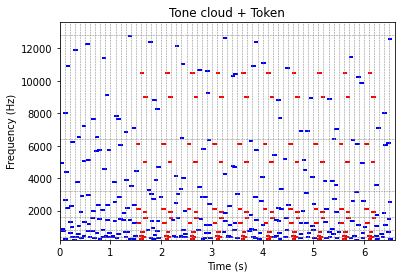

In [3]:
#poner de rojo los tokens

import os
from os import mkdir
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import sounddevice as sd
import soundfile as sf

#Defining variables
ntokenreps = 10  #how many times the target repeats in a trial
tonedur = 0.05 
minf = 200
maxf = 12800
noct = 6
spectral_density = [1] #tones per octave   
temporal_density = [10] #tones per second
tempi = [0.5] #s, the inter-repeat interval of tokens 
tempilist = [0.5]
tokendur = 0.2 #target duration
tokendur_ingrid =int(temporal_density[0]*tokendur)
tempi_ingrid = int(temporal_density[0]*tempi[0])

fs = 44100 #generate sounds with this fs
fs48 = 48828 #convert to this fs for TDT equipment
maxf48k = fs48/2
trialseed = 888

tokenstartrange=np.linspace(1,1.5, num=6) #range from where I can choose to strat my token
tokenstart=np.random.choice(tokenstartrange)
mintokenstart = 1 
maxtokenstart = 1.5 #first token starts between 1-1.5s into (random) tone cloud
np.random.seed(trialseed)  #command to set the seed
ntrialspercond = 60
stimdb = 85
wrongtotaltime=tokenstart+(tempi*ntokenreps)
totaltime=maxtokenstart+(tempi[0]*ntokenreps)+1/temporal_density[0]
targetrms = (10**(-94/20))*(10**(stimdb/20)) #convertion of dB to amplitude. the number we would use
targetrms_wav = 0.1 #0.4  

#Computing hann envelope (for creating a smooth on and off ramp to sounds)
hanndur = 0.005
thann = np.arange(1/fs, hanndur+1/fs, 1/fs)
ramp = np.cos(2*np.pi*0.5/hanndur*thann)
ttone = np.arange(1/fs, tonedur+1/fs, 1/fs)
env = np.ones(ttone.shape)
env[:len(ramp)] = np.flip(ramp)
env[-len(ramp):] = ramp
env=(env+1)/2
#plt.plot(ttone, env)

#Creating the freq_list and the timegrid
trialct = 0
for s in range(len(spectral_density)):
    specdens = spectral_density[s]
    freq_list = np.logspace(np.log10(minf),np.log10(maxf),specdens*noct+1)

timegrid=np.linspace(0,totaltime, num=int(totaltime/(1/(temporal_density[0]))+2)) 


#Looping trough the desired number of subjects and number of trials.
    
            
            #Creating random background(latencymat, freqmat)
latencymat = np.zeros((len(timegrid) - 1, len(freq_list) - 1))
freqmat = np.zeros((len(timegrid) - 1, len(freq_list) - 1))

for t in range(len(timegrid) - 2):     
    for f in range(len(freq_list) - 1):

        start_time = timegrid[t]
        end_time = timegrid[t + 1]
        ftimetone = np.random.uniform(start_time, end_time) - start_time

        fstart_time = freq_list[f]
        fend_time = freq_list[f + 1]
        ftone = np.random.uniform(fstart_time, fend_time)

        latencymat[t, f] = ftimetone
        freqmat[t, f] = ftone

latencymat = latencymat.transpose()
freqmat = freqmat.transpose()

#             print("Latencymat:\n",latencymat)
#             print("\nFreqmat:\n",freqmat)


#Creating token and startids
tokenstart=np.random.choice(tokenstartrange)
tokenstarttime=tokenstart # just redefining the name
tokenendtime=tokenstarttime+tokendur 

tokenstartcondition = np.isclose(timegrid, tokenstarttime)
start_idx=np.where(tokenstartcondition)[0][0]

end_idx=int(start_idx+tokendur_ingrid)
latencytoken=latencymat[:,np.arange(start_idx,end_idx,1)]
freqtoken=freqmat[:,np.arange(start_idx,end_idx,1)]


latencyshape = latencymat.shape
sid = np.arange(start_idx,latencyshape[1],tempi_ingrid)
startids = [x for x in sid if x<(latencyshape[1]-2)]

#             print("latencytoken:\n",latencytoken)
#             print("\nfreqtoken:\n",freqtoken)
#             print("\nstartids:\n", startids)

#Creating the final soundmat of the tonecloud+token
token_latencymat = latencymat
token_freqmat = freqmat


baselatencymat=np.zeros(latencymat.shape)
basefreqmat=np.zeros(freqmat.shape)


#Replacing sections of tone cloud with token
for s in startids:
    token_latencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken
    token_freqmat[:, np.arange(s,s+tokendur_ingrid,1)] = freqtoken
    
    baselatencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken
    basefreqmat[:, np.arange(s,s+tokendur_ingrid,1)] = freqtoken

    binarbasefreqmat = np.where(basefreqmat > 0, 1, basefreqmat)
    binarbaselatencymat = np.where(baselatencymat > 0, 1, baselatencymat)

tokensoundmat=np.zeros(int(totaltime*fs))

    

for t in range(len(timegrid) - 2):     
    for f in range(len(freq_list) - 1):

        ftimetone = token_latencymat[f,t]
        ftone = token_freqmat[f,t]

        grid_start = timegrid[t]

        amp = np.sin(2*np.pi*ftone*ttone) #make the tone
        amp = amp*env #hanning env already calculated outside

        tonestartsamp = int((grid_start+ftimetone)*fs)+1
        toneendsamp = tonestartsamp+len(amp)

        #print(grid_start,tonestartsamp)


        tokensoundmat[tonestartsamp:toneendsamp]=tokensoundmat[tonestartsamp:toneendsamp]+amp
        plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='blue', linewidth=2)
        if binarbaselatencymat[f,t]==1:
            plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='red', linewidth=2)
        
        
        
for t in timegrid:
    linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
for f in freq_list:
    linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title(f'Tone cloud + Token')
plt.xlim(0, totaltime)
plt.ylim(minf, maxf+800)
plt.show()


#Creating and saving wav file

#             trial= str(nt).zfill(2)
#             filename= f"exp1_subject{subjID}_trial{trial}.wav"
#             path_filename = os.path.join(subjpath, filename)

#             tokensoundmat = tokensoundmat/max(abs(tokensoundmat))
#             sf.write(path_filename, tokensoundmat, fs)


#             print(f"Saved: {path_filename}")



In [5]:
latencymat = np.zeros((len(timegrid)-1, len(freq_list)-1))
freqmat = np.zeros((len(timegrid)-1, len(freq_list)-1))


for t in range(len(timegrid)-2):     
    for f in range(len(freq_list)-1):
            
        start_time = timegrid[t]
        end_time = timegrid[t+1]
        ftimetone = np.random.uniform(start_time, end_time)-start_time
        
        fstart_time = freq_list[f]
        fend_time = freq_list[f+1]
        ftone = np.random.uniform(fstart_time, fend_time)
        
        latencymat[t, f] = ftimetone
        freqmat[t, f] = ftone


latencymat=latencymat.transpose()
freqmat=freqmat.transpose()

print("Final latencymat:\n",latencymat)

print("\nFinal freqmat:\n",freqmat)

Final latencymat:
 [[8.59560606e-02 3.01718196e-03 6.48509039e-02 9.15874371e-03
  6.35459341e-03 7.27317961e-02 6.58436560e-02 6.59822668e-02
  3.85321529e-02 2.07882831e-02 1.23531775e-02 9.08589105e-03
  8.64116400e-02 6.36995708e-02 3.93812964e-02 9.26559691e-02
  2.58680322e-02 7.58494604e-02 2.31853109e-02 2.51285224e-02
  1.64612171e-02 4.44436748e-02 6.85247430e-02 7.85866316e-02
  6.68236038e-02 1.08839747e-02 5.07653018e-02 9.71796554e-02
  3.69113050e-02 4.73277629e-02 6.71864153e-02 3.23039598e-02
  9.51407299e-02 5.23107941e-02 7.75142686e-02 1.18819055e-02
  3.08820859e-02 9.82153124e-02 3.18396292e-02 8.57576419e-03
  2.70545889e-02 1.31381308e-02 5.46852340e-03 1.44212802e-02
  2.34158691e-02 6.32719889e-02 3.73816246e-02 2.25655465e-02
  7.39537186e-02 9.28295127e-02 1.99459663e-02 2.76856004e-02
  2.93245035e-02 6.23064324e-03 4.12296563e-02 2.50127105e-02
  2.67777356e-02 2.10276776e-02 2.55622425e-02 5.76094122e-02
  5.01213412e-02 4.84340366e-02 4.49881446e-02 4.59

In [6]:

tokenstart=np.random.choice(tokenstartrange)
tokenstarttime=tokenstart # just redefining the name
tokenendtime=tokenstarttime+tokendur 

tokenstartcondition = np.isclose(timegrid, tokenstarttime)
start_idx=np.where(tokenstartcondition)[0][0]

end_idx=int(start_idx+tokendur_ingrid)
latencytoken=latencymat[:,np.arange(start_idx,end_idx,1)]
freqtoken=freqmat[:,np.arange(start_idx,end_idx,1)]
    

print("Final latencytoken:\n",latencytoken)

print("\nFinal freqtoken:\n",freqtoken)

Final latencytoken:
 [[0.09265597 0.02586803]
 [0.08465976 0.00860515]
 [0.03943621 0.0697547 ]
 [0.02543767 0.0595555 ]
 [0.02174181 0.05365361]
 [0.09603472 0.0624378 ]]

Final freqtoken:
 [[  225.39171671   383.03324467]
 [  412.49095457   689.30491051]
 [ 1265.95303627  1566.10616959]
 [ 2077.19651606  1910.46584346]
 [ 6124.39785276  5016.26458337]
 [10468.47600227  8974.88709637]]


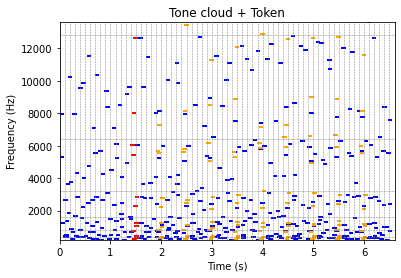

In [51]:
#token withouth jitter

token_latencymat = latencymat
token_freqmat = freqmat

latencyshape = latencymat.shape
sid = np.arange(start_idx,latencyshape[1],tempi_ingrid)
startids = [x for x in sid if x<(latencyshape[1]-2)]

maxjitter = 2 # semitones, plus or minus
jitterfreqtoken=np.zeros(freqtoken.shape)
jitterperfreq=np.zeros(freqtoken.shape)


# replace sections of tone cloud with token

first_startid=startids[0]
token_latencymat[:, np.arange(first_startid,first_startid+tokendur_ingrid,1)] = latencytoken
token_freqmat[:, np.arange(first_startid,first_startid+tokendur_ingrid,1)] = freqtoken

tokensoundmat=np.zeros(int(totaltime*fs))

for t in range(len(timegrid) - 2):     
    for f in range(len(freq_list) - 1):

        ftimetone = token_latencymat[f,t]
        ftone = token_freqmat[f,t]

        grid_start = timegrid[t]

        amp = np.sin(2*np.pi*ftone*ttone) #make the tone
        amp = amp*env #hanning env already calculated outside

        tonestartsamp = int((grid_start+ftimetone)*fs)+1
        toneendsamp = tonestartsamp+len(amp)

        #print(grid_start,tonestartsamp)


        tokensoundmat[tonestartsamp:toneendsamp]=tokensoundmat[tonestartsamp:toneendsamp]+amp

        plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='blue', linewidth=2)


for i in range(freqtoken.shape[0]):
    for j in range(tokendur_ingrid):
        plt.plot([timegrid[first_startid] + latencytoken[i, j], timegrid[first_startid] + latencytoken[i, j] + tonedur],
                 [token_freqmat[i, first_startid + j], token_freqmat[i, first_startid + j]], 
                 color='red', linewidth=2)

for s in startids[1:]:
    token_latencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken

    maxjitter = 2 # semitones, plus or minus
    jitterfreqtoken=np.zeros(freqtoken.shape)
    jitterperfreq=np.zeros(freqtoken.shape)
    
    baselatencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken
    basefreqmat[:, np.arange(s,s+tokendur_ingrid,1)] = jitterfreqtoken

    binarbasefreqmat = np.where(basefreqmat > 0, 1, basefreqmat)
    binarbaselatencymat = np.where(baselatencymat > 0, 1, baselatencymat)

    
    token_freqmat[:, np.arange(s,s+tokendur_ingrid,1)] = jitterfreqtoken
    
    for i in range(freqtoken.shape[0]):
        for j in range(tokendur_ingrid):
            plt.plot([timegrid[s] + latencytoken[i, j], timegrid[s] + latencytoken[i, j] + tonedur],
                     [token_freqmat[i, s + j], token_freqmat[i, s + j]],
                     color='orange', linewidth=2)

# print("Final token_latencymat:\n",token_latencymat)
# print("\nFinal token_freqmat:\n",token_freqmat)


for t in timegrid:
    linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
for f in freq_list:
    linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Tone cloud + Token')
plt.xlim(0, totaltime)
plt.ylim(minf, maxf+800)
plt.show()

In [7]:
maxjitter = 2 # semitones, plus or minus
jitterfreqtoken=np.zeros(freqtoken.shape)
jitterperfreq=np.zeros(freqtoken.shape)

for i in range(freqtoken.shape[0]):
    for j in range(freqtoken.shape[1]):
        randjitterST = np.random.random(1)*maxjitter*2-maxjitter
        jitterfreq = freqtoken[i,j] * 2**(randjitterST/12)
        jitterfreqtoken[i][j]=jitterfreq
        jitterperfreq[i][j]=randjitterST
        
print(jitterperfreq)
print(jitterfreqtoken)

[[-0.78669332 -1.99200256]
 [ 1.70993622 -0.72526088]
 [-0.0205903   0.49126637]
 [ 0.84716141 -0.56990147]
 [-0.28075332 -0.4365515 ]
 [-1.46435967 -0.82192723]]
[[ 215.37887008  341.40150083]
 [ 455.31253185  661.02456515]
 [1264.44827999 1611.1835775 ]
 [2181.36999546 1848.59947125]
 [6025.87980241 4891.35492696]
 [9619.41761875 8558.74849625]]


[[ 0.96348774  0.8313313 ]
 [ 0.94437834  0.03134166]
 [-0.88777623 -0.81158873]
 [ 0.27529095 -0.98866541]
 [ 0.5614123  -0.61993616]
 [-0.70331261  0.69939401]]
[[  238.29111198   401.87510842]
 [  435.61712735   690.55393424]
 [ 1202.67141397  1494.38266511]
 [ 2110.49092189  1804.42062307]
 [ 6326.25787106  4839.81566034]
 [10051.71760882  9344.88314813]]
[[-0.63099198  0.29506573]
 [-0.74090107  0.0653472 ]
 [ 0.37144525 -0.07853727]
 [-0.79649845  0.40762514]
 [ 0.63493695 -0.40948072]
 [ 0.10518848 -0.16268373]]
[[  217.32465151   389.61748529]
 [  395.21034941   691.91167921]
 [ 1293.40819506  1559.0176345 ]
 [ 1983.7948498   1955.9821796 ]
 [ 6353.1823062   4899.00937178]
 [10532.27529848  8890.94527396]]
[[-0.74175906  0.84344095]
 [-0.49993539  0.7199215 ]
 [-0.78335866  0.63737614]
 [ 0.56888996  0.77725626]
 [-0.85849098  0.84505376]
 [-0.69699093 -0.72421464]]
[[  215.93861303   402.15631074]
 [  400.74963335   718.57350955]
 [ 1209.94711993  1624.83891488]
 [ 2146.587835

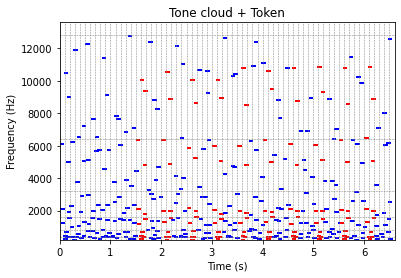

In [12]:
#token with jitter

token_latencymat = latencymat
token_freqmat = freqmat

latencyshape = latencymat.shape
sid = np.arange(start_idx,latencyshape[1],tempi_ingrid)
startids = [x for x in sid if x<(latencyshape[1]-2)]

maxjitter = 2 # semitones, plus or minus
jitterfreqtoken=np.zeros(freqtoken.shape)
jitterperfreq=np.zeros(freqtoken.shape)

jbaselatencymat=np.zeros(latencymat.shape)
jbasefreqmat=np.zeros(freqmat.shape)

# replace sections of tone cloud with token

first_startid=startids[0]
token_latencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken
token_freqmat[:, np.arange(s,s+tokendur_ingrid,1)] = freqtoken

for s in startids:
    token_latencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken

    maxjitter = 1 # semitones, plus or minus
    jitterfreqtoken=np.zeros(freqtoken.shape)
    jitterperfreq=np.zeros(freqtoken.shape)
    
    for i in range(freqtoken.shape[0]):
        for j in range(freqtoken.shape[1]):
            randjitterST = np.random.random(1)*maxjitter*2-maxjitter
            jitterfreq = freqtoken[i,j] * 2**(randjitterST/12)
            jitterfreqtoken[i][j]=jitterfreq
            jitterperfreq[i][j]=randjitterST
    print(jitterperfreq)
    print(jitterfreqtoken)
    
    token_freqmat[:, np.arange(s,s+tokendur_ingrid,1)] = jitterfreqtoken
    
    jbaselatencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken
    jbasefreqmat[:, np.arange(s,s+tokendur_ingrid,1)] = jitterfreqtoken

    jbinarbasefreqmat = np.where(jbasefreqmat > 0, 1, jbasefreqmat)


print("Final token_latencymat:\n",token_latencymat)
print("\nFinal token_freqmat:\n",token_freqmat)

tokensoundmat=np.zeros(int(totaltime*fs))

for t in range(len(timegrid) - 2):     
    for f in range(len(freq_list) - 1):

        ftimetone = token_latencymat[f,t]
        ftone = token_freqmat[f,t]

        grid_start = timegrid[t]

        amp = np.sin(2*np.pi*ftone*ttone) #make the tone
        amp = amp*env #hanning env already calculated outside

        tonestartsamp = int((grid_start+ftimetone)*fs)+1
        toneendsamp = tonestartsamp+len(amp)

        #print(grid_start,tonestartsamp)


        tokensoundmat[tonestartsamp:toneendsamp]=tokensoundmat[tonestartsamp:toneendsamp]+amp

        plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='blue', linewidth=2)
        if jbinarbasefreqmat[f,t]==1:
            plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='red', linewidth=2)
            
#                 plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='orange', linewidth=2)
            

for t in timegrid:
    linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
for f in freq_list:
    linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Tone cloud + Token')
plt.xlim(0, totaltime)
plt.ylim(minf, maxf+800)
plt.show()

import sounddevice as sd
sd.play(tokensoundmat,fs)

In [23]:
latencyshape = latencymat.shape
sid = np.arange(start_idx,latencyshape[1],tempi_ingrid)
startids = [x for x in sid if x<(latencyshape[1]-2)]


In [26]:
# leave latencymat and freqmat alone
token_latencymat = latencymat
token_freqmat = freqmat

# replace sections of tone cloud with token
for s in startids:
    token_latencymat[:, np.arange(s,s+tokendur_ingrid,1)] = latencytoken
    token_freqmat[:, np.arange(s,s+tokendur_ingrid,1)] = freqtoken
print(startids)
print("Final token_latencymat:\n",token_latencymat)

print("\nFinal token_freqmat:\n",token_freqmat)

[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
Final token_latencymat:
 [[0.09635955 0.06559153 0.07946248 0.06861291 0.04405717 0.02831995
  0.05011858 0.01470638 0.09674212 0.07696893 0.00057618 0.07372139
  0.08506076 0.0028919  0.0571031  0.00057618 0.07372139 0.0709229
  0.05442252 0.00083359 0.00057618 0.07372139 0.04432217 0.01076949
  0.01199754 0.00057618 0.07372139 0.09238929 0.00174159 0.03502853
  0.00057618 0.07372139 0.09962779 0.06873748 0.04093523 0.00057618
  0.07372139 0.00028706 0.00736823 0.07165925 0.00057618 0.07372139
  0.0856303  0.04816515 0.0702038  0.00057618 0.07372139 0.04309351
  0.07046779 0.06736009 0.00057618 0.07372139 0.06422102 0.07504638
  0.05363248 0.00057618 0.07372139 0.05848895 0.04347173 0.0184993
  0.00057618 0.07372139 0.00278816 0.01875592 0.08288583 0.        ]
 [0.04005293 0.09347285 0.0239556  0.07295164 0.05922716 0.07863005
  0.02017153 0.03456223 0.03570837 0.01783037 0.08970082 0.07791194
  0.09992149 0.05391519 0.04511292 0.08970082 0

0.0 1536
0.09999999999999999 8068
0.19999999999999998 10519
0.3 14621
0.39999999999999997 21390
0.49999999999999994 22966
0.6 27524
0.7 31443
0.7999999999999999 38014
0.8999999999999999 43281
0.9999999999999999 46504
1.0999999999999999 49410
1.2 54008
1.2999999999999998 59930
1.4 64263
1.4999999999999998 67481
1.5999999999999999 71460
1.7 76058
1.7999999999999998 83451
1.9 84745
1.9999999999999998 91511
2.0999999999999996 93510
2.1999999999999997 98108
2.3 103596
2.4 110198
2.5 114420
2.5999999999999996 115560
2.6999999999999997 120158
2.8 126153
2.9 132278
2.9999999999999996 132740
3.0999999999999996 137610
3.1999999999999997 142208
3.3 147444
3.4 150590
3.4999999999999996 154631
3.5999999999999996 159660
3.6999999999999997 164258
3.8 169446
3.8999999999999995 173144
3.9999999999999996 180035
4.1 181710
4.199999999999999 186308
4.3 193149
4.3999999999999995 195028
4.5 201711
4.6 203760
4.699999999999999 208358
4.8 214321
4.8999999999999995 218923
5.0 222260
5.1 225810
5.19999999999999

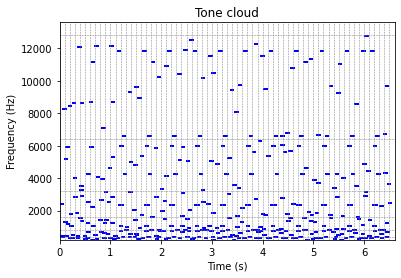

In [27]:
soundmat=np.zeros(int(totaltime*fs))

for f in range(len(freq_list)-1):
    for t in range(len(timegrid)-2):
        ftimetone = token_latencymat[f,t]
        ftone = token_freqmat[f,t]
            
        grid_start = timegrid[t]
        
        amp = np.sin(2*np.pi*ftone*ttone) #make the tone
        amp = amp*env #hanning env already calculated outside
            
        tonestartsamp = int((grid_start+ftimetone)*fs)+1
        toneendsamp = tonestartsamp+len(amp)
        
        print(grid_start,tonestartsamp)
            
        
            
        soundmat[tonestartsamp:toneendsamp]=soundmat[tonestartsamp:toneendsamp]+amp
            
        plt.plot([grid_start+ftimetone, grid_start+ftimetone + tonedur],[ftone, ftone], color='blue', linewidth=2)
        
for t in timegrid:
    linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
for f in freq_list:
    linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Tone cloud')
plt.xlim(0, totaltime)
plt.ylim(minf, maxf+800)
plt.show()


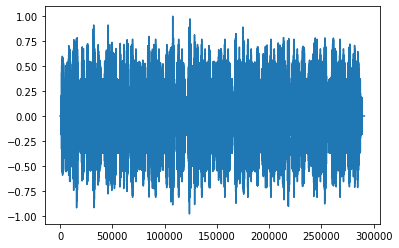

In [68]:
soundmat = soundmat/max(abs(soundmat)) # before saving to wav
plt.plot(soundmat)

In [69]:
import sounddevice as sd
sd.play(soundmat,fs)

## The first versions and old functions

### Creating an audible tone cloud

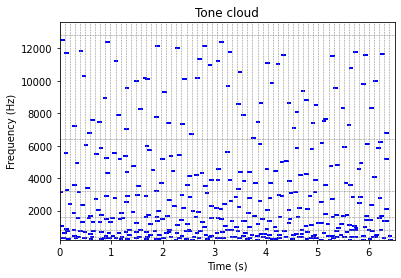

In [7]:
soundmat=np.zeros(int(totaltime*fs))

def audible_tonecloud(timegrid,freq_list):
    for t in range(len(timegrid)-2):     
        for f in range(len(freq_list)-1):
            start_time = timegrid[t]
            end_time = timegrid[t+1]
            ftimetone = np.random.uniform(start_time, end_time)
        
            fstart_time = freq_list[f]
            fend_time = freq_list[f+1]
            ftone = np.random.uniform(fstart_time, fend_time)
            
            amp = np.sin(2*np.pi*ftone*ttone) #make the tone
            amp = amp*env #hanning env already calculated outside
            
            tonestartsamp = int(ftimetone*fs)+1
            toneendsamp = tonestartsamp+len(amp)
            
            soundmat[tonestartsamp:toneendsamp]=soundmat[tonestartsamp:toneendsamp]+amp
            
            plt.plot([ftimetone, ftimetone + tonedur],[ftone, ftone], color='blue', linewidth=2)
            
    for t in timegrid:
        linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
    for f in freq_list:
        linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Tone cloud')
    plt.xlim(0, totaltime)
    plt.ylim(minf, maxf+800)
    plt.show()
    
audible_tonecloud(timegrid,freq_list)

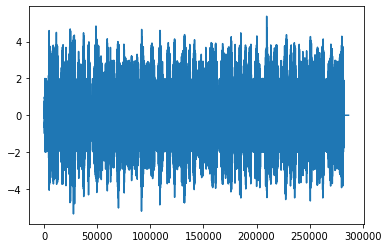

In [14]:
plt.plot(soundmat)

In [16]:
#Creating the folder in a specified path
example_num=1
setID= f"tonecloud_{example_num}"
#mkdir(f"C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/set_{setID}")


In [17]:
filename="first_tonecloud"
output_path = f"C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/set_{setID}"

def saving_tonecloud (soundmat,fs,output_path,filename):
    import soundfile as sf
    import os
    path_filename = os.path.join(output_path, f"{filename}.wav")
    sf.write(path_filename, soundmat, fs)
    
    print(f"{filename} succesfully saved in {output_path}")
    return path_filename
        

In [18]:
saving_tonecloud (soundmat,fs,output_path,filename)

first_tonecloud succesfully saved in C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/set_tonecloud_1


'C:/Users/Laptop Elitebook/Documents/NEUROCIENCIAS/practicas-tesis/Audios/set_tonecloud_1\\first_tonecloud.wav'

### Steps I followed for the creation of the grid + tonecloud

In [93]:
def grid_creation(timegrid,freq_list):
    for t in timegrid:
        linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
    for f in freq_list:
        linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Grid')
    plt.xlim(0, totaltime)
    plt.ylim(minf, maxf+800)
    plt.show()
    

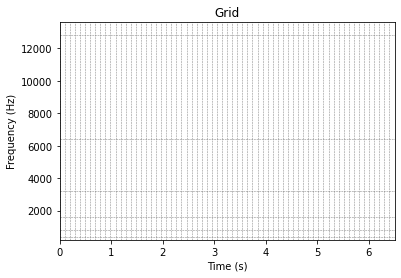

In [94]:
grid_creation(timegrid,freq_list)

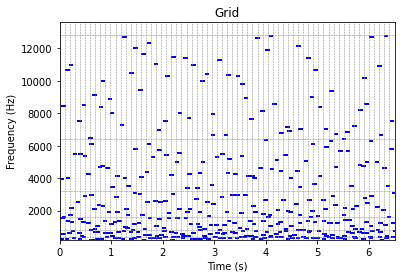

In [95]:
def grid_creation(timegrid,freq_list):
    for t in range(len(timegrid)-1):     
        for f in range(len(freq_list)-1):
            start_time = timegrid[t]
            end_time = timegrid[t+1]
            ftimetone = np.random.uniform(start_time, end_time)
        
            fstart_time = freq_list[f]
            fend_time = freq_list[f+1]
            ftone = np.random.uniform(fstart_time, fend_time)
            
            amp = np.sin(2*np.pi*ftone*ttone) #make the tone
            amp = amp*env #hanning env already calculated outside

            plt.plot([ftimetone, ftimetone + tonedur],[ftone, ftone], color='blue', linewidth=2)
            
    for t in timegrid:
        linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
    for f in freq_list:
        linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Grid')
    plt.xlim(0, totaltime)
    plt.ylim(minf, maxf+800)
    plt.show()
grid_creation(timegrid,freq_list)

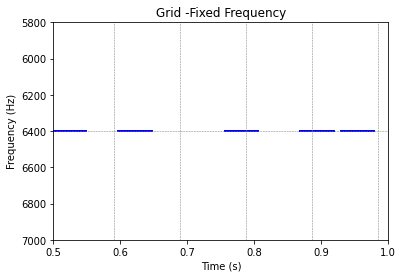

In [97]:
fixed_freq=freq_list[5]

trialtimetones=[]
t=0
def grid_creation_freqfixed(timegrid,freq_list):
    for t in range(len(timegrid)-1): 
        start_time = timegrid[t]
        end_time = timegrid[t+1]  
        ftimetone = np.random.uniform(start_time, end_time)
        trialtimetones.append(start_time)
            
        plt.plot([ftimetone, ftimetone + tonedur], [fixed_freq, fixed_freq], color='blue', linewidth=2)
            
    for t in timegrid:
        linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
    for f in freq_list:
        linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Grid -Fixed Frequency')
    plt.xlim(0.5, 1) #we made a zoom to see if we were getting one tone per grid.
    plt.ylim(7000, 5800)
    plt.show()
grid_creation_freqfixed(timegrid,freq_list)


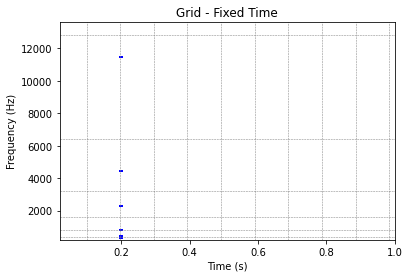

In [100]:
fixed_time=timegrid[2]
def grid_creation_timefixed(timegrid,freq_list):
    for f in range(len(freq_list)-1):
        fstart_time = freq_list[f]
        fend_time = freq_list[f+1]
        ftone = np.random.uniform(fstart_time, fend_time)
        amp = np.sin(2*np.pi*ftone*ttone) #make the tone
        amp = amp*env #hanning env already calculated outside
            
        plt.plot([fixed_time,fixed_time+0.005], [ftone,ftone], color='blue', linewidth=2)
            
    for t in timegrid:
        linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
    for f in freq_list:
        linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Grid - Fixed Time')
    plt.xlim(0.02, 1)
    plt.ylim(minf, maxf+800)
    plt.show()
grid_creation_timefixed(timegrid,freq_list)

In [ ]:
np.zeros()

### Code to create and save a random tone

In [ ]:
trialct= 0
def create_randomtone(output_path, minf, maxf):
    for s in range(len(spectral_density)):
        specdens = spectral_density[s]
        freq_list = np.logspace(np.log10(minf),np.log10(maxf),specdens*noct+1)
        for t in range(len(temporal_density)):
            tempdens = temp_dens_ptonepergriddt[s]
            for n in range(ntrialspercond):
                for N in range(len(tempi)):
                    trialct = trialct+1
                    startt = round((maxtokenstart-mintokenstart)/griddt*np.random.rand()) + mintokenstart/griddt # time of first token start in units of n griddt
                    generating sound
                    ftone = np.random.uniform(minf, maxf) #pick a random tone frequency between minf and maxf
                    amp = np.sin(2*np.pi*ftone*ttone) #make the tone
                    amp = amp*env #hanning env already calculated outside
                    wav_filename = f"{output_path}/trial_{trialct}_freq_{int(ftone)}_Hz.wav"
                    write(wav_filename, fs, amp.astype(np.float32))
                    txt_filename = f"{output_path}/trial_{trialct}_freq_{int(ftone)}.txt"
                    np.savetxt(txt_filename, amp, fmt='%0.6f')
                

### Intentos fallidos y borradores:
(No están en orden cronológico)

In [ ]:
#random tone creation outside a def function:
for s in range(len(spectral_density)):
        specdens = spectral_density[s]
        freq_list = np.logspace(np.log10(minf),np.log10(maxf),specdens*noct+1)
        for t in range(len(temporal_density)):
            tempdens = temp_dens_ptonepergriddt[s]
            for n in range(ntrialspercond):
                for N in range(len(tempi)):
                    trialct = trialct+1
                    startt = round((maxtokenstart-mintokenstart)/griddt*np.random.rand()) + mintokenstart/griddt # time of first token start in units of n griddt
                    generating sound
                    ftone = np.random.uniform(minf, maxf) #pick a random tone frequency between minf and maxf
                    amp = np.sin(2*np.pi*ftone*ttone) #make the tone
                    amp = amp*env #hanning env already calculated outside
                    wav_filename = f"{output_path}/trial_{trialct}_freq_{int(ftone)}_Hz.wav"
                    write(wav_filename, fs, amp.astype(np.float32))
                    txt_filename = f"{output_path}/trial_{trialct}_freq_{int(ftone)}.txt"
                    np.savetxt(txt_filename, amp, fmt='%0.6f')

In [33]:
freq_list #así se ve freq_list

array([  200.,   400.,   800.,  1600.,  3200.,  6400., 12800.])

In [130]:
timegrid #así se ve timegrid

array([0.        , 0.1001503 , 0.2003006 , 0.3004509 , 0.4006012 ,
       0.5007515 , 0.6009018 , 0.7010521 , 0.8012024 , 0.90135271,
       1.00150301, 1.10165331, 1.20180361, 1.30195391, 1.40210421,
       1.50225451, 1.60240481, 1.70255511, 1.80270541, 1.90285571,
       2.00300601, 2.10315631, 2.20330661, 2.30345691, 2.40360721,
       2.50375752, 2.60390782, 2.70405812, 2.80420842, 2.90435872,
       3.00450902, 3.10465932, 3.20480962, 3.30495992, 3.40511022,
       3.50526052, 3.60541082, 3.70556112, 3.80571142, 3.90586172,
       4.00601202, 4.10616232, 4.20631263, 4.30646293, 4.40661323,
       4.50676353, 4.60691383, 4.70706413, 4.80721443, 4.90736473,
       5.00751503, 5.10766533, 5.20781563, 5.30796593, 5.40811623,
       5.50826653, 5.60841683, 5.70856713, 5.80871743, 5.90886774,
       6.00901804])

In [73]:
def grid_creation(timegrid,freq_list):
    for s in range(spectral_density[0]):
        for td in range(temporal_density[0]):
            for t in timegrid:
                linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
                td=td+1
                ftone = np.random.uniform(minf, maxf) #pick a random tone frequency between minf and maxf
                ftimetone=np.random.uniform(0, timegrid)
                amp = np.sin(2*np.pi*ftone*ttone) #make the tone
                amp = amp*env #hanning env already calculated outside
                plt.scatter(td,ftone)
            for f in freq_list:
                linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.title('Grid')
            plt.xlim(0, totaltime)
            plt.ylim(minf, maxf+800)
            plt.show()

In [250]:
#indexing with booleans (it was useful when the timegrid had numbers like 1.12121 instead of 1.1)

def token_creation(latencymat,freqmat,tokendur):
    for t in timegrid:
        tokenstart=np.random.choice(tokenstartrange)
        tokenstarttime=tokenstart # just redefining the name
        tokenendtime=tokenstarttime+tokendur 
        
        tokenstartcondition=timegrid<tokenstarttime
        tokenendcondition=timegrid>tokenendtime
        
        start_idx=np.where(tokenstartcondition==False)[0][0]
        end_idx=np.where(tokenendcondition==True)[0][0]
        tokestartgrid=timegrid[start_idx]
        tokenendgrid=timegrid[end_idx]
        
        print("Start_idx:", start_idx,"\nEnd_idx",end_idx,"\nTokestartgrid:", tokestartgrid, "\ntokenendgrid",tokenendgrid )

        return tokenstartcondition


token_creation(latencymat, freqmat, tokendur)

Start_idx: 14 
End_idx 16 
Tokestartgrid: 1.3787878787878787 
tokenendgrid 1.5757575757575757


(1.3, 1.5)

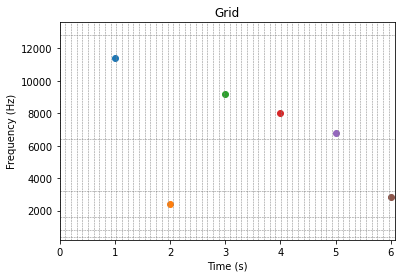

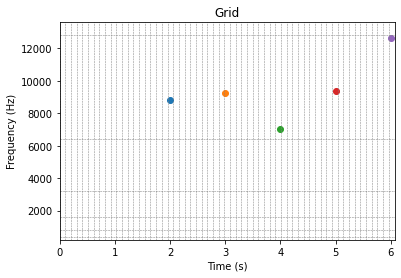

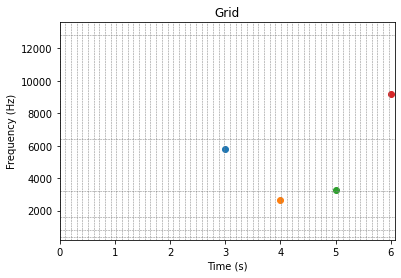

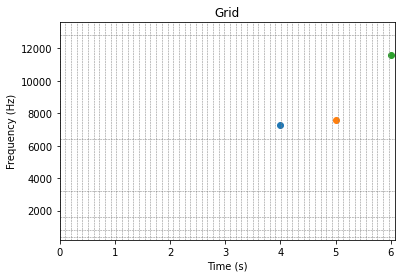

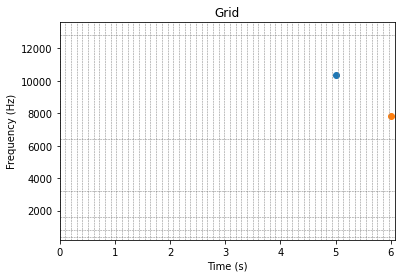

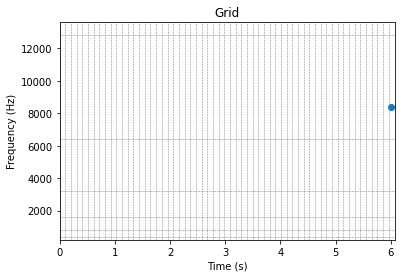

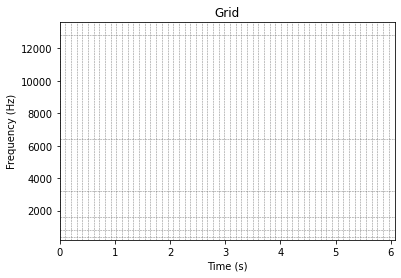

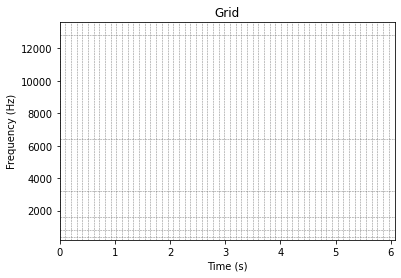

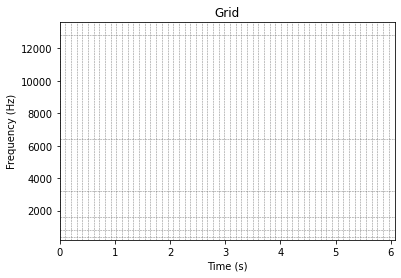

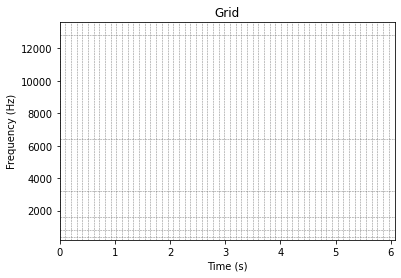

In [74]:
grid_creation(timegrid,freq_list)

In [80]:
ftimetones = []  
td=0
def grid_creation(timegrid,freq_list):
    for t in range(int(totaltime)): 
        start_time = t  
        end_time = t + 1  

        for i in range(temporal_density[0]):  
            ftimetone = np.random.uniform(start_time, end_time)  
                 
        for s in range(spectral_density[0]):
                linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
                ftone = np.random.uniform(minf, maxf) #pick a random tone frequency between minf and maxf
                amp = np.sin(2*np.pi*ftone*ttone) #make the tone
                amp = amp*env #hanning env already calculated outside
                plt.scatter(ftimetone,ftone)
                for f in freq_list:
                    linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
                plt.xlabel('Time (s)')
                plt.ylabel('Frequency (Hz)')
                plt.title('Grid')
                plt.xlim(0, totaltime)
                plt.ylim(minf, maxf+800)
                plt.show()

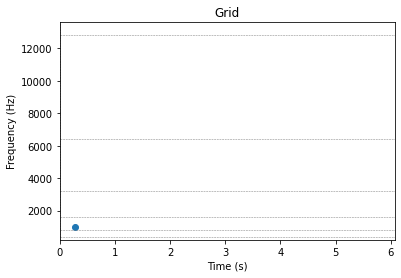

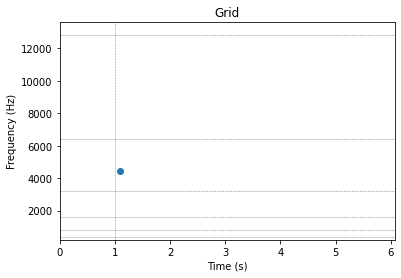

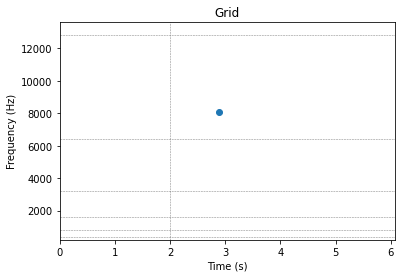

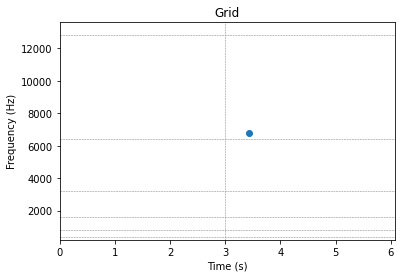

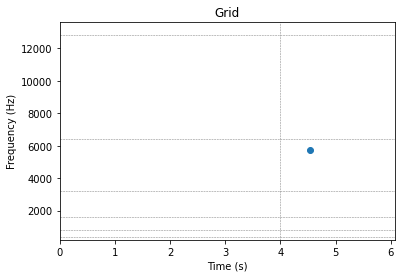

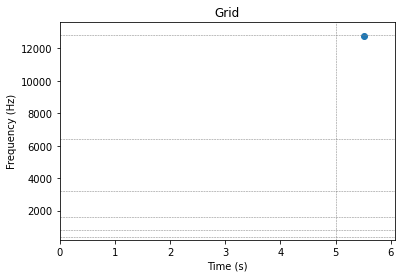

In [81]:
grid_creation(timegrid,freq_list)


In [114]:
len(timegrid)

60

In [123]:
timegrid

array([0.        , 0.1028158 , 0.2056316 , 0.3084474 , 0.4112632 ,
       0.51407901, 0.61689481, 0.71971061, 0.82252641, 0.92534221,
       1.02815801, 1.13097381, 1.23378961, 1.33660541, 1.43942122,
       1.54223702, 1.64505282, 1.74786862, 1.85068442, 1.95350022,
       2.05631602, 2.15913182, 2.26194762, 2.36476343, 2.46757923,
       2.57039503, 2.67321083, 2.77602663, 2.87884243, 2.98165823,
       3.08447403, 3.18728983, 3.29010563, 3.39292144, 3.49573724,
       3.59855304, 3.70136884, 3.80418464, 3.90700044, 4.00981624,
       4.11263204, 4.21544784, 4.31826365, 4.42107945, 4.52389525,
       4.62671105, 4.72952685, 4.83234265, 4.93515845, 5.03797425,
       5.14079005, 5.24360586, 5.34642166, 5.44923746, 5.55205326,
       5.65486906, 5.75768486, 5.86050066, 5.96331646, 6.06613226])

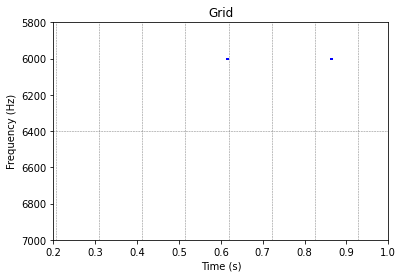

In [125]:
def grid_creation_ffixed(timegrid,freq_list):
    for t in range(len(timegrid)-1): 
        start_time = t
        end_time = t+1

        for i in range(temporal_density[0]):  
            ftimetone = np.random.uniform(start_time, end_time)
            
            plt.plot([ftimetone, ftimetone + tonedur], [6000, 6000], color='blue', linewidth=2)
            
    for t in timegrid:
        linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
    for f in freq_list:
        linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Grid')
    plt.xlim(0.2, 1)
    plt.ylim(7000, 5800)
    plt.show()
grid_creation_ffixed(timegrid,freq_list)

In [126]:
timegrid

array([0.        , 0.10307712, 0.20615424, 0.30923137, 0.41230849,
       0.51538561, 0.61846273, 0.72153985, 0.82461698, 0.9276941 ,
       1.03077122, 1.13384834, 1.23692546, 1.34000259, 1.44307971,
       1.54615683, 1.64923395, 1.75231107, 1.8553882 , 1.95846532,
       2.06154244, 2.16461956, 2.26769668, 2.37077381, 2.47385093,
       2.57692805, 2.68000517, 2.78308229, 2.88615942, 2.98923654,
       3.09231366, 3.19539078, 3.2984679 , 3.40154503, 3.50462215,
       3.60769927, 3.71077639, 3.81385351, 3.91693064, 4.02000776,
       4.12308488, 4.226162  , 4.32923912, 4.43231625, 4.53539337,
       4.63847049, 4.74154761, 4.84462473, 4.94770186, 5.05077898,
       5.1538561 , 5.25693322, 5.36001034, 5.46308747, 5.56616459,
       5.66924171, 5.77231883, 5.87539595, 5.97847308, 6.0815502 ,
       6.18462732, 6.28770444, 6.39078156])

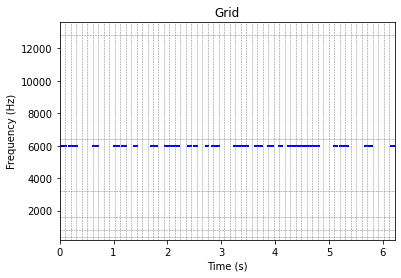

In [11]:
grid_creation_ffixed(timegrid,freq_list)

In [75]:
def grid_creation_t(timegrid,freq_list):
    for t in range(int(totaltime)): 
        start_time = t  
        end_time = t + 1  

        for i in range(temporal_density[0]):  
            ftimetone = np.random.uniform(start_time, end_time)
            plt.scatter(ftimetone,600)
            
    for t in timegrid:
        linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
    for f in freq_list:
        linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Grid')
    plt.xlim(0, totaltime)
    plt.ylim(minf, maxf+800)
    plt.show()

In [ ]:
def grid_creation(timegrid,freq_list):
    for td in range(temporal_density[0]):
        for s in range(spectral_density[0]):
                td=td+1
                ftone = np.random.uniform(minf, maxf) #pick a random tone frequency between minf and maxf
                ftimetone=np.random.uniform(0, timegrid)
                amp = np.sin(2*np.pi*ftone*ttone) #make the tone
                amp = amp*env #hanning env already calculated outside
                plt.scatter(td,ftone)
        for f in freq_list:
            linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
    
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Grid')
        plt.xlim(0, totaltime)
        plt.ylim(minf, maxf+800)
        plt.show()

In [55]:
ftimetones=[]
time=0
for t in range(int(temporal_density[0]*totaltime)):
    for i in range(temporal_density[0]):
        ftimetone=np.random.uniform(0, totaltime)
        ftimetones.append(ftimetone)
        
        

In [21]:
ftimetones = []  

for t in range(int(totaltime)): 
    start_time = t  
    end_time = t + 1  

    for i in range(temporal_density[0]):  
        ftimetone = np.random.uniform(start_time, end_time)  
        ftimetones.append(ftimetone)  

print(ftimetones)

[0.8746844079883702, 0.2677773557125669, 0.28448631315506523, 0.027195176237154284, 0.385699284822557, 0.44032308190500347, 0.4161966031956361, 0.5799528372699668, 0.3662295328140369, 0.3493414663609782, 1.1669068706863623, 1.131852857424184, 1.161308738330991, 1.2102767762956455, 1.5834007445310618, 1.8317984562824403, 1.0152022332748318, 1.4983105831351222, 1.690234391689628, 1.6014576448610756, 2.608499732938063, 2.6124200003115017, 2.98272273809991, 2.15832489589502, 2.7937408305105005, 2.2556224246136853, 2.068479912759321, 2.0004160662586807, 2.054079108977743, 2.6952899602720235, 3.3868469585243943, 3.2881464538518, 3.9687748075525406, 3.452602399757453, 3.8990411925911803, 3.631717823273557, 3.5988139964869417, 3.576094121854113, 3.4128946058277987, 3.5462517199497765, 4.471268056893366, 4.9121863962545556, 4.209987667515014, 4.635223476179962, 4.616198260643526, 4.473220401397325, 4.539355673334283, 4.238741536553418, 4.536740958109805, 4.50121341207096, 5.412683830487397, 5.6

In [225]:

def token_in_mat(latencytoken, freqtoken, tempi):
    for r in range(ntokenreps):
        tokenstart=np.random.choice(tokenstartrange)
        tokenstarttime=tokenstart # just redefining the name
        tokenendtime=tokenstarttime+tokendur 
        
        tokenstartcondition = np.isclose(timegrid, tokenstarttime)
        start_idx=np.where(tokenstartcondition)[0][0]
        end_idx=int(start_idx+tokendur_ingrid-1)
        latencymat[start_idx:end_idx+1] = latencytoken
        freqmat[start_idx:end_idx+1] = freqtoken
        start_idx += tempi_ingrid
        
        return latencymat, freqmat
                    
        
            
    
    
    
token_in_mat(latencytoken, freqtoken, tempi)


(array([[2.08045532e-02, 9.46093515e-02, 1.36187153e-02, 5.71828012e-03,
         9.11672203e-02, 3.23099612e-02],
        [1.25418481e-01, 1.23971077e-01, 1.04704112e-01, 1.98592581e-01,
         1.51001292e-01, 1.86382948e-01],
        [2.78611223e-01, 2.95306550e-01, 2.02897257e-01, 2.60797725e-01,
         2.91432806e-01, 2.79362654e-01],
        [3.09898865e-01, 3.55236472e-01, 3.20972401e-01, 3.04267904e-01,
         3.33789778e-01, 3.19209901e-01],
        [4.00379457e-01, 4.58229982e-01, 4.30432035e-01, 4.86444850e-01,
         4.08685678e-01, 4.41612155e-01],
        [5.17108023e-01, 5.79985172e-01, 5.67896782e-01, 5.73094656e-01,
         5.50291429e-01, 5.11666821e-01],
        [6.89244226e-01, 6.91867582e-01, 6.01861180e-01, 6.29131271e-01,
         6.87848526e-01, 6.99038290e-01],
        [7.77889548e-01, 7.80187413e-01, 7.41342246e-01, 7.00012706e-01,
         7.57414280e-01, 7.50523023e-01],
        [8.06888586e-01, 8.85545979e-01, 8.23695511e-01, 8.14140515e-01,
       

In [22]:
len(ftimetones)

60

In [33]:
ftimetone=np.random.uniform(0, timegrid)
ftimetone

array([0.        , 0.07183239, 0.12108094, 0.17903891, 0.12067538,
       0.48560671, 0.38147877, 0.51125067, 0.0587691 , 0.27762847,
       0.06233391, 0.03300629, 0.5538293 , 0.84328641, 0.840885  ,
       1.19456566, 0.15844045, 1.72119333, 0.88282739, 0.28883695,
       1.34665292, 0.45354467, 0.82469741, 1.96020407, 0.92038718,
       1.38514473, 0.90291202, 2.03594254, 1.77489901, 2.86711138,
       2.28559622, 0.38199684, 3.20278849, 1.76319104, 3.25716151,
       0.93642415, 0.16316485, 0.73997124, 1.78694962, 1.78280832,
       1.43398305, 4.13980446, 0.15324854, 0.29317391, 1.5954257 ,
       0.94001139, 4.4325264 , 0.96198592, 2.94593482, 0.88444471,
       2.47178946, 2.23672054, 1.71099874, 2.00094044, 0.31447585,
       2.19879858, 4.91337426, 0.87109194, 2.47311488, 5.55993692,
       3.84814324])

ValueError: x and y must be the same size

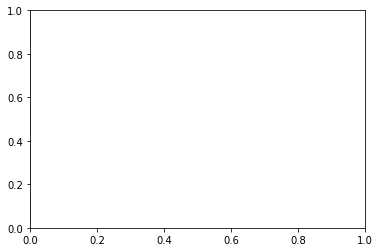

In [30]:
grid_creation(timegrid,freq_list)

In [ ]:
def tones(timegrid, freq_list, temporal_density, spectral_density):
    

In [ ]:
timetones = []  
freqtones = []
for g in timegrid:
    for f in freq_list:
        linetime=plt.axvline(x=g, color='gray', linestyle='--', linewidth=0.5)
        linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)
        for t in range(temporal_density[0]):
            for s in range(spectral_density[0]):
                t=timetones
                ftone = np.random.uniform(minf, maxf) #pick a random tone frequency between minf and maxf
                amp = np.sin(2*np.pi*ftone*ttone) #make the tone
                amp = amp*env #hanning env already calculated outside
                timetones.append(t)  
                freqtones.append(ftone)
                    
for t, f in zip(timetones, freqtones):
    plt.plot([t], [f], 'bo')  

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Grid')
plt.xlim(0, totaltime)
plt.ylim(minf, maxf+800)
plt.show()

In [ ]:
timetones

In [69]:
tones

[array([2.35202666e-06, 4.62251049e-06, 6.05925710e-05, ...,
        7.88778941e-05, 6.91200619e-06, 4.81987181e-06]),
 array([ 5.54913468e-06,  9.98038551e-06,  1.11605840e-04, ...,
        -1.12317353e-04, -1.22211865e-05, -9.50026329e-06]),
 array([2.59278522e-06, 5.07612808e-06, 6.61046160e-05, ...,
        9.73103427e-05, 1.19407713e-05, 1.25648923e-05]),
 array([ 1.19267378e-05,  8.13348901e-06, -5.74186941e-05, ...,
        -1.14179509e-04, -4.31010958e-06,  9.74774394e-06]),
 array([ 4.88404883e-06,  9.01528900e-06,  1.05808942e-04, ...,
        -3.74221092e-05, -8.45197163e-06, -1.14430358e-05]),
 array([ 1.24069458e-05,  5.18538303e-06, -9.21546930e-05, ...,
        -4.40771719e-05,  1.04217553e-05,  9.25331790e-06]),
 array([5.95510641e-06, 1.05166447e-05, 1.13550588e-04, ...,
        1.06190194e-04, 8.23027839e-06, 2.73526089e-06]),
 array([3.94985625e-06, 7.50711229e-06, 9.28605756e-05, ...,
        2.11205686e-06, 4.17219819e-06, 7.69501532e-06]),
 array([ 1.14827767e-05,

In [66]:
for g in timegrid:
    # Para cada valor de g en la cuadrícula de tiempo
    for f in freq_list:
        # Genera una cantidad de tonos basada en las densidades establecidas
        for s in range(spectral_density):  # Ya no es necesario usar índice
            for t in range(temporal_density):  # Ya no es necesario usar índice
                # Genera una frecuencia aleatoria entre minf y maxf
                ftone = np.random.uniform(minf, maxf)
                # Calcula la amplitud de ese tono
                amp = np.sin(2 * np.pi * ftone * ttone)
                amp = amp * env  # Aplica la envolvente predefinida
                # Dibuja el tono en la gráfica
                plt.scatter(g, ftone, color='blue', marker='o', s=20)

# Etiquetas y visualización
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Random Tones with Spectral and Temporal Density')
plt.xlim(0, totaltime)
plt.ylim(minf, maxf + 800)

# Mostrar la gráfica con tonos aleatorios
plt.show()


TypeError: 'list' object cannot be interpreted as an integer

In [48]:
i=0
f=0
t=0
for i in range(temporal_density[0],spectral_density[0]):
    i=i+1
    for f in range(len(freq_list)):
        f=f+1
        for t in range(len(timegrid)):
            t=t+1
            ftone = np.random.uniform(minf, maxf) #pick a random tone frequency between minf and maxf
            amp = np.sin(2*np.pi*ftone*ttone) #make the tone
            amp = amp*env #hanning env already calculated outside
            for t in timegrid:
                linetime=plt.axvline(x=t, color='gray', linestyle='--', linewidth=0.5)
    
            for f in freq_list:
                linefreq=plt.axhline(y=f, color='gray', linestyle='--', linewidth=0.5)

            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.title('Grid')
            plt.xlim(0, totaltime)
            plt.ylim(minf, maxf+800)
            plt.show()
                   
                   
        
    


In [16]:
for s in range(len(spectral_density)):
    specdens = spectral_density[s]
    freq_list = np.logspace(np.log10(minf),np.log10(maxf),specdens*noct+1)
    for t in range(len(temporal_density)):
        for n in range(ntrialspercond):
            for N in range(len(tempi)):
                trialct = trialct+1
                startt =(maxtokenstart-mintokenstart) + mintokenstart # time of first token start 
                startt_ms = startt*1000
                seqdur = startt+ntokenreps
                
     
                
                #generating pure tones
                #ftone = np.random.uniform(minf, maxf) #pick a random tone frequency between minf and maxf
                #amp = np.sin(2*np.pi*ftone*ttone) #make the tone
                #amp = amp*env #hanning env already calculated outside
                #wav_filename = f"{output_path}/trial_{trialct}_freq_{int(ftone)}_Hz.wav"
                #write(wav_filename, fs, amp.astype(np.float32))
                #txt_filename = f"{output_path}/trial_{trialct}_freq_{int(ftone)}.txt"
                #np.savetxt(txt_filename, amp, fmt='%0.6f')


In [8]:
i=0
while i<=tokendur:
    

token=

4

In [32]:
totaltime

6.410821643286573

In [33]:
len(freq_list)

31

In [34]:
time_freq=(totaltime+1),len(freq_list)
time_freq

(7.410821643286573, 31)

In [91]:
freq_list

array([  200.        ,   237.841423  ,   282.84271247,   336.3585661 ,
         400.        ,   475.682846  ,   565.68542495,   672.7171322 ,
         800.        ,   951.365692  ,  1131.3708499 ,  1345.43426441,
        1600.        ,  1902.731384  ,  2262.7416998 ,  2690.86852881,
        3200.        ,  3805.46276801,  4525.48339959,  5381.73705762,
        6400.        ,  7610.92553602,  9050.96679919, 10763.47411525,
       12800.        ])

In [43]:
for i in range(0,7):
    tokenstartrange=np.linspace(1,1.5, num=500) #range from where I can choose to strat my token
    tokenstart=np.random.choice(tokenstartrange)
    
    

In [49]:
octavas=[]
for i in range(0, len(freq_list), 5):
    octava = freq_list[i:i+4]
    octavas.append(octava)
octavas

[array([200.        , 229.739671  , 263.90158215, 303.1433133 ]),
 array([400.        , 459.479342  , 527.80316431, 606.2866266 ]),
 array([ 800.        ,  918.958684  , 1055.60632862, 1212.57325321]),
 array([1600.        , 1837.917368  , 2111.21265724, 2425.14650642]),
 array([3200.        , 3675.83473599, 4222.42531447, 4850.29301283]),
 array([6400.        , 7351.66947198, 8444.85062895, 9700.58602567]),
 array([12800.])]

In [51]:
octavas[0]

array([200.        , 229.739671  , 263.90158215, 303.1433133 ])

## Next steps:
1. make a function for the random background tone cloud
2. make a function for startids and token generation
3. make a function to stick tone cloud into background
4. make a function to save as wav (normalise so values in soundmat don't exceed +/-1
5. make a big function that does all of that for N number of trials and a given random seed, and saves all wav files in a folder called expt1_Ntrials_seed(or subjID)... filenames should be expt1_seed_trialX (if N<10, save it as '0n')

## thinking ahead...
### Experiment 2 adds jitter to freqtoken
1. not in a function, try taking a freqtoken and add jitter to each value in the token
2. make a new function that loops through startids, computes the jittered token, and sticks the jittered token into background (basically replacing step 3 from expt 1)
3. create a new big function that does all of that for N number of trials and a given random seed, and saves all wav files in a folder called expt1_Ntrials_seed(or subjID)... filenames should be expt1_seed_trialX (if N<10, save it as '0n')
4. the step 5 from before should now use a filename/structure of expt2_...



In [50]:
soundmat=np.zeros(time_freq)
soundmat

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
for i in range():
    while 

In [127]:
freq_list

array([  200.        ,   237.841423  ,   282.84271247,   336.3585661 ,
         400.        ,   475.682846  ,   565.68542495,   672.7171322 ,
         800.        ,   951.365692  ,  1131.3708499 ,  1345.43426441,
        1600.        ,  1902.731384  ,  2262.7416998 ,  2690.86852881,
        3200.        ,  3805.46276801,  4525.48339959,  5381.73705762,
        6400.        ,  7610.92553602,  9050.96679919, 10763.47411525,
       12800.        ])

In [37]:
octaves = []
grids = []
for f in range(0, len(freq_list)-1, 4):
    octava_min = freq_list[f]  
    octava_max = freq_list[f+4] if f+4 < len(freq_list) else freq_list[-1]  
    grid = np.linspace(octava_min, octava_max, spectral_density[0], endpoint=False)
    octaves.append((octava_min, octava_max))  
    grids.append(grid)  

In [47]:
octaves

[(200.00000000000003, 348.22022531844965),
 (348.22022531844965, 606.2866266041592),
 (606.2866266041592, 1055.6063286183164),
 (1055.6063286183164, 1837.9173679952573),
 (1837.9173679952573, 3200.0000000000023),
 (3200.0000000000023, 5571.523605095198),
 (5571.523605095198, 9700.586025666553),
 (9700.586025666553, 12800.000000000013)]

In [40]:
i = freq_list[0] 
j = 0
tones = []

for f in range(spectral_density[0]):
    while j < len(octaves):  
        if i in octaves[j]:
            tone = np.random.uniform(octaves[j][0], octaves[j][-1])
        tones.append(tone)  
        i += 1  
        j += 1  


In [46]:
for j in range(len(octavas)):
    for f in range(spectral_density[0]):  
        tone = np.random.uniform(octavas[j][0], octavas[j][-1])
        tones.append(tone)  
        print(tone)
        


274.87300306723
219.6667889879619
244.55992747366037
207.9781482032896
250.3216371083465
419.19713137930864
511.39308527686137
354.8235753157737
499.6748517761622
495.8934444501441
763.5299160337152
790.136615968926
773.2035789015442
620.3312925084872
627.3607460589027
1503.224177607564
1367.8367371589893
1289.1182853764412
1109.6571235882984
1088.1302891256898
1954.8258667274783
2421.107873888655
1865.9706713040837
1995.3505033316194
1889.5200090483422
3646.8449903225364
4383.219097955251
4386.685692716883
3718.852058415869
4266.399027879268
6972.167003049871
6574.17205716355
6581.0025364735475
6715.7626606911435
5846.39110854829
10354.627207792886
11618.985965757112
12570.473818773726
10810.651249987659
12494.158766576951


In [28]:
freq_list

array([  200.        ,   237.841423  ,   282.84271247,   336.3585661 ,
         400.        ,   475.682846  ,   565.68542495,   672.7171322 ,
         800.        ,   951.365692  ,  1131.3708499 ,  1345.43426441,
        1600.        ,  1902.731384  ,  2262.7416998 ,  2690.86852881,
        3200.        ,  3805.46276801,  4525.48339959,  5381.73705762,
        6400.        ,  7610.92553602,  9050.96679919, 10763.47411525,
       12800.        ])

In [36]:
while freq_list()

2.7990383196104363